In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import sqlite3
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import re
from dateutil.parser import parse
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Quality Check

In [ ]:
# Loading data
flights_data=pd.read_csv('/content/drive/My Drive/Flights.csv')
airport_codes_data=pd.read_csv('/content/drive/My Drive/Airport_Codes.csv')
tickets_data=pd.read_csv('/content/drive/My Drive/Tickets.csv')

<ipython-input-14-c22431a4463c>:2: DtypeWarning: Columns (3,13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  flights_data=pd.read_csv('/content/drive/My Drive/Flights.csv')


In [ ]:
flights_data.head()

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
0,2019-03-02,WN,N955WN,4591,14635,RSW,"Fort Myers, FL",11042,CLE,"Cleveland, OH",-8.000,-6.000,0.000,143.000,1025.000,0.970
1,2019-03-02,WN,N8686A,3231,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",1.000,5.000,0.000,135.000,930.000,0.550
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.000,4.000,0.000,132.000,930.000,0.910
3,2019-03-02,WN,N413WN,5498,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",11.000,14.000,0.000,136.000,930.000,0.670
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.000,-17.000,0.000,151.000,1005.000,0.620


In [ ]:
flights_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB


**Data Quality Issue 1: Wrong data type in flights data set**:

The Distance column has a wrong data type. This has to be converted to the float data type as it is very important in cost calculations

**Rectifing wrong data type in flights data set**

In [ ]:
# check if DISTANCE contains string entries that cannot be converted to float becasue it has an object datatype

pd.to_numeric(flights_data['DISTANCE'].dropna(), errors='coerce').isna().sum()

2110

In [ ]:
# check if these values are unique enough to be viewed together

flights_data['DISTANCE'][pd.to_numeric(flights_data['DISTANCE'], errors='coerce').isna()].nunique()

4

In [ ]:
flights_data['DISTANCE'][pd.to_numeric(flights_data['DISTANCE'], errors='coerce').isna()].unique()

array(['Hundred', nan, 'Twenty', 'NAN', '****'], dtype=object)

In [ ]:
flights_data['DISTANCE'][pd.to_numeric(flights_data['DISTANCE'], errors='coerce').isna()].value_counts()

****       2070
NAN          20
Hundred      10
Twenty       10
Name: DISTANCE, dtype: int64

In [ ]:
# investigating the **** value further
flights_data.loc[flights_data['DISTANCE'] =='****'].head(20)

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
1910981,3/24/19,AA,N932AN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-3.000,-16.000,0.000,134,****,0.891
1910982,3/25/19,AA,N945NN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-6.000,-28.000,0.000,129,****,0.972
1910983,3/26/19,AA,N977NN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-5.000,-27.000,0.000,120,****,0.357
1910984,3/27/19,AA,N971AN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-1.000,-12.000,0.000,122,****,0.937
1910985,3/28/19,AA,N937AN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-3.000,-9.000,0.000,129,****,0.794
1910986,3/29/19,AA,N804NN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-3.000,-13.000,0.000,133,****,0.595
1910987,3/30/19,AA,N890NN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",3.000,-14.000,0.000,124,****,0.882
1910988,3/31/19,AA,N950AN,1414,12478,JFK,"New York, NY",13930,ORD,"Chicago, IL",-2.000,-9.000,0.000,117,****,0.456
1911142,3/18/19,AA,N879NN,1425,11298,DFW,"Dallas/Fort Worth, TX",10529,BDL,"Hartford, CT",10.000,-7.000,0.000,170,****,0.659
1911143,3/19/19,AA,N982AN,1425,11298,DFW,"Dallas/Fort Worth, TX",10529,BDL,"Hartford, CT",1.000,-7.000,0.000,172,****,0.456


In [ ]:
flights_data.loc[flights_data['DISTANCE'] =='****'].iloc[999:1020]

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE
1913325,3/23/19,AA,N976AN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-2.000,-10.000,0.000,149,****,0.968
1913326,3/24/19,AA,N886NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-7.000,-18.000,0.000,141,****,0.515
1913327,3/25/19,AA,N954NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-4.000,-2.000,0.000,141,****,0.421
1913328,3/26/19,AA,N952NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",1.000,-14.000,0.000,144,****,0.825
1913329,3/27/19,AA,N947NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-8.000,-15.000,0.000,138,****,0.671
1913330,3/28/19,AA,N971NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-1.000,-1.000,0.000,156,****,0.556
1913331,3/29/19,AA,N930NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-3.000,-17.000,0.000,142,****,0.995
1913332,3/30/19,AA,N997NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",-3.000,-18.000,0.000,140,****,0.533
1913333,3/31/19,AA,N978NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",3.000,-12.000,0.000,142,****,0.759
1913334,3/1/19,AA,N908NN,1433,15370,TUL,"Tulsa, OK",11057,CLT,"Charlotte, NC",-3.000,-9.000,0.000,112,****,0.694


In [ ]:
# These '****'seems to be a notation for N/A
# They would be replaced with distance values from the same origin and destination

In [ ]:
# for ease of slicing and analysis, a new column is created

flights_data['ROUTE'] = flights_data['ORIGIN'].astype('str') + '-' + flights_data['DESTINATION'].astype('str')
'''
    The new ROUTE column represents the combination of origin and destination
    for a given flight
'''

flights_data.loc[(flights_data['ROUTE'] =="SNA-DFW")]['DISTANCE'].value_counts()
# this shows that the **** notation can be replaced by corresponding numbers
# in this orgin and destination combination **** means 1205.0

1205.0    748
****      310
Name: DISTANCE, dtype: int64

In [ ]:
# investigating the hundred and twenty notations further
flights_data.loc[(flights_data['DISTANCE'] =="Hundred") |
                 (flights_data['DISTANCE'] =="Twenty")]

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ROUTE
1910839,1/2/19,UA,N782SA,5656,14635,RSW,"Fort Myers, FL",13232,MDW,"Chicago, IL",5.000,8.000,0.000,164,Hundred,0.802,RSW-MDW
1910862,3/26/19,AA,N981NN,1403,10821,BWI,"Baltimore, MD",11298,DFW,"Dallas/Fort Worth, TX",-2.000,-34.000,0.000,170,Twenty,0.395,BWI-DFW
1911344,1/2/19,UA,N782SA,5656,14635,RSW,"Fort Myers, FL",13232,MDW,"Chicago, IL",5.000,8.000,0.000,164,Hundred,0.802,RSW-MDW
1911367,3/26/19,AA,N981NN,1403,10821,BWI,"Baltimore, MD",11298,DFW,"Dallas/Fort Worth, TX",-2.000,-34.000,0.000,170,Twenty,0.395,BWI-DFW
1911849,1/2/19,UA,N782SA,5656,14635,RSW,"Fort Myers, FL",13232,MDW,"Chicago, IL",5.000,8.000,0.000,164,Hundred,0.802,RSW-MDW
1911872,3/26/19,AA,N981NN,1403,10821,BWI,"Baltimore, MD",11298,DFW,"Dallas/Fort Worth, TX",-2.000,-34.000,0.000,170,Twenty,0.395,BWI-DFW
1912354,1/2/19,UA,N782SA,5656,14635,RSW,"Fort Myers, FL",13232,MDW,"Chicago, IL",5.000,8.000,0.000,164,Hundred,0.802,RSW-MDW
1912377,3/26/19,AA,N981NN,1403,10821,BWI,"Baltimore, MD",11298,DFW,"Dallas/Fort Worth, TX",-2.000,-34.000,0.000,170,Twenty,0.395,BWI-DFW
1912859,1/2/19,UA,N782SA,5656,14635,RSW,"Fort Myers, FL",13232,MDW,"Chicago, IL",5.000,8.000,0.000,164,Hundred,0.802,RSW-MDW
1912882,3/26/19,AA,N981NN,1403,10821,BWI,"Baltimore, MD",11298,DFW,"Dallas/Fort Worth, TX",-2.000,-34.000,0.000,170,Twenty,0.395,BWI-DFW


In [ ]:
#further investigation reveals further problems
flights_data.loc[(flights_data['ROUTE'] =="RSW-MDW")]['DISTANCE'].value_counts()


1105.0     394
Hundred     10
2213        10
2312        10
3221        10
Name: DISTANCE, dtype: int64

In [ ]:
# The solution is to replace all distance records for each orgin and destination with the distance that occurs the most

In [ ]:
#Checking for negative string values
flights_data['DISTANCE'].str.contains('-').any()

True

In [ ]:
#checking for negative values
((pd.to_numeric(flights_data['DISTANCE'].dropna(), errors='coerce').dropna())<=0).sum()

230

In [ ]:
# solution to negative string values is to convert to float and chnage to absolute value

In [ ]:
def flight_distance_cleaner (flight_data):
    '''
        Replace all distance records for each orgin and destination with the distance that occurs the most
        Changes datatype of DISTANCE column to float
        Ensures any negaive value is converted to absolute value
    '''



    # Convert 'DISTANCE' column to numeric, setting non-numeric values to NaN
    flight_data['DISTANCE']=pd.to_numeric(flight_data['DISTANCE'], errors='coerce')

    # Calculate the mode of 'DISTANCE' for each 'ROUTE' considering only numeric values
    mode_distance_by_route = flight_data.groupby('ROUTE')['DISTANCE'].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

    # Assign the mode values back to the original DataFrame
    flight_data['DISTANCE'] = flight_data['ROUTE'].map(mode_distance_by_route)

    flight_data['DISTANCE'] = flight_data['DISTANCE'].astype(float)

    flight_data['DISTANCE'] = flight_data['DISTANCE'].abs()

    return flight_data


In [ ]:
# check if entries in FL_DATE column are of format yyyy-mm-dd

date_format=re.compile("^\d{4}-\d{2}-\d{2}$")
(~flights_data['FL_DATE'].str.match(date_format)).sum()


5050

**Data Quality Issue 2: Wrong and inconsistent date format in flights_data**:

The date format in the flights_data are inconsistent and wrong. The format for all the date entries would be converted to yyyy-mm-dd


**Rectifing Wrong and inconsistent date format in flights_data**

In [ ]:
def flight_date_converter (flight_data):
    '''
        Converts the different date formats in FL_DATE column to "YYYY-MM-DD" format
    '''
    # convert date string to datetime objects
    flight_data['FL_DATE']=pd.to_datetime(flight_data['FL_DATE'], errors='coerce')
    flight_data['FL_DATE']= flight_data['FL_DATE'].dt.strftime('%Y-%m-%d')

    return flight_data


In [ ]:
# Checking for missing data
flights_data.isna().sum()

FL_DATE                  0
OP_CARRIER               0
TAIL_NUM             12156
OP_CARRIER_FL_NUM        0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
ORIGIN_CITY_NAME         0
DEST_AIRPORT_ID          0
DESTINATION              0
DEST_CITY_NAME           0
DEP_DELAY            50351
ARR_DELAY            55991
CANCELLED                0
AIR_TIME             56551
DISTANCE               630
OCCUPANCY_RATE         310
ROUTE                    0
dtype: int64

In [ ]:
# investigating departure delay
flights_data.loc[flights_data['DEP_DELAY']==0]
# this shows that na does not represent 0

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ROUTE
2,2019-03-02,WN,N201LV,3383,14635,RSW,"Fort Myers, FL",11066,CMH,"Columbus, OH",0.000,4.000,0.000,132.000,930.000,0.910,RSW-CMH
4,2019-03-02,WN,N7832A,6933,14635,RSW,"Fort Myers, FL",11259,DAL,"Dallas, TX",0.000,-17.000,0.000,151.000,1005.000,0.620,RSW-DAL
9,2019-03-02,WN,N7889A,4899,14635,RSW,"Fort Myers, FL",12339,IND,"Indianapolis, IN",0.000,11.000,0.000,150.000,945.000,0.700,RSW-IND
26,2019-03-02,WN,N8671D,2791,14679,SAN,"San Diego, CA",10140,ABQ,"Albuquerque, NM",0.000,-19.000,0.000,69.000,628.000,0.880,SAN-ABQ
41,2019-03-02,WN,N265WN,3455,14679,SAN,"San Diego, CA",12191,HOU,"Houston, TX",0.000,-18.000,0.000,143.000,1313.000,0.430,SAN-HOU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915728,3/28/19,AA,N930AN,1426,14122,PIT,"Pittsburgh, PA",13930,ORD,"Chicago, IL",0.000,-16.000,0.000,$$$,****,0.448,PIT-ORD
1915767,3/10/19,AA,N141NN,1428,11298,DFW,"Dallas/Fort Worth, TX",14771,SFO,"San Francisco, CA",0.000,-1.000,0.000,200,****,0.888,DFW-SFO
1915838,3/11/19,AA,N906NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",0.000,-7.000,0.000,145,****,0.517,SNA-DFW
1915840,3/13/19,AA,N908NN,1432,14908,SNA,"Santa Ana, CA",11298,DFW,"Dallas/Fort Worth, TX",0.000,-14.000,0.000,136,****,0.703,SNA-DFW


In [ ]:

flights_data.loc[flights_data['ARR_DELAY'].isnull()]

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ROUTE
126,2019-03-02,WN,N926WN,5417,14683,SAT,"San Antonio, TX",12191,HOU,"Houston, TX",NaN,NaN,1.000,NaN,192.000,0.430,SAT-HOU
130,2019-03-02,WN,N799SW,5307,14683,SAT,"San Antonio, TX",12889,LAS,"Las Vegas, NV",NaN,NaN,1.000,NaN,1069.000,0.670,SAT-LAS
136,2019-03-02,WN,N440LV,4585,14683,SAT,"San Antonio, TX",14107,PHX,"Phoenix, AZ",NaN,NaN,1.000,NaN,843.000,0.900,SAT-PHX
182,2019-03-02,WN,N456WN,2669,14771,SFO,"San Francisco, CA",12892,LAX,"Los Angeles, CA",NaN,NaN,1.000,NaN,337.000,0.610,SFO-LAX
190,2019-03-02,WN,N7828A,5371,14771,SFO,"San Francisco, CA",14107,PHX,"Phoenix, AZ",NaN,NaN,1.000,NaN,651.000,0.690,SFO-PHX
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915693,3/24/19,AA,N868NN,1425,11298,DFW,"Dallas/Fort Worth, TX",10529,BDL,"Hartford, CT",NaN,NaN,1.000,NaN,****,0.518,DFW-BDL
1915716,3/16/19,AA,NaN,1426,14122,PIT,"Pittsburgh, PA",13930,ORD,"Chicago, IL",NaN,NaN,1.000,$$$,****,0.692,PIT-ORD
1915781,3/24/19,AA,N991AU,1428,11298,DFW,"Dallas/Fort Worth, TX",14771,SFO,"San Francisco, CA",NaN,NaN,1.000,NaN,****,0.851,DFW-SFO
1915785,3/28/19,AA,N156AN,1428,11298,DFW,"Dallas/Fort Worth, TX",14771,SFO,"San Francisco, CA",NaN,NaN,1.000,NaN,****,0.605,DFW-SFO


<Axes: xlabel='DEP_DELAY', ylabel='Count'>

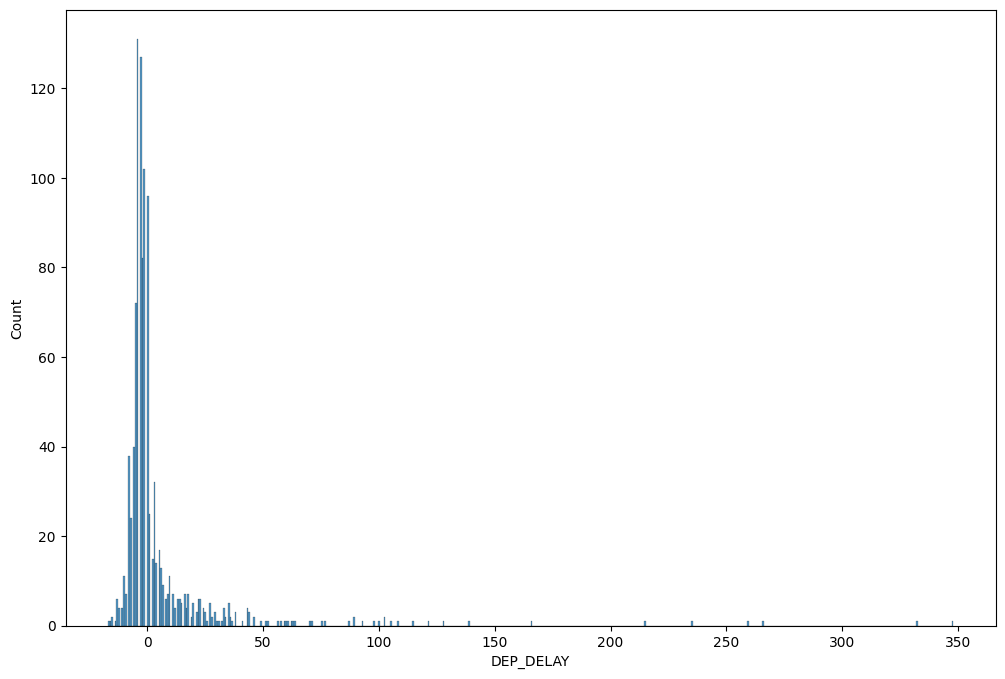

In [ ]:
# randomly selecting routes to see distribution of depature delay time
data= flights_data.loc[(flights_data['ROUTE'] =="SNA-DFW")]['DEP_DELAY']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

<Axes: xlabel='DEP_DELAY', ylabel='Count'>

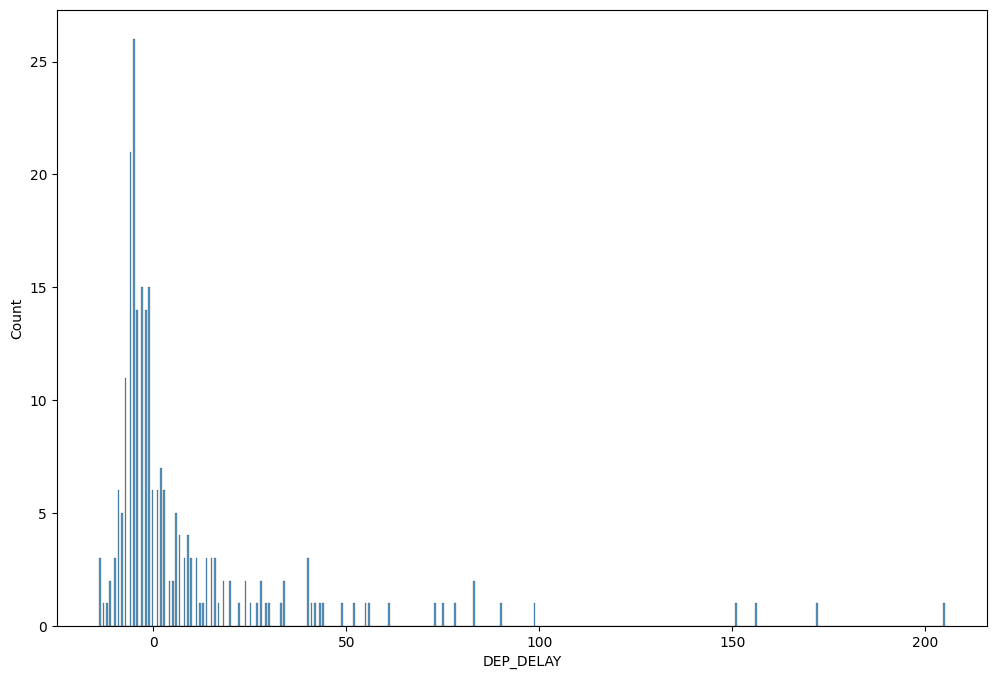

In [ ]:
data= flights_data.loc[(flights_data['ROUTE'] =="SAN-ABQ")]['DEP_DELAY']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

<Axes: xlabel='DEP_DELAY', ylabel='Count'>

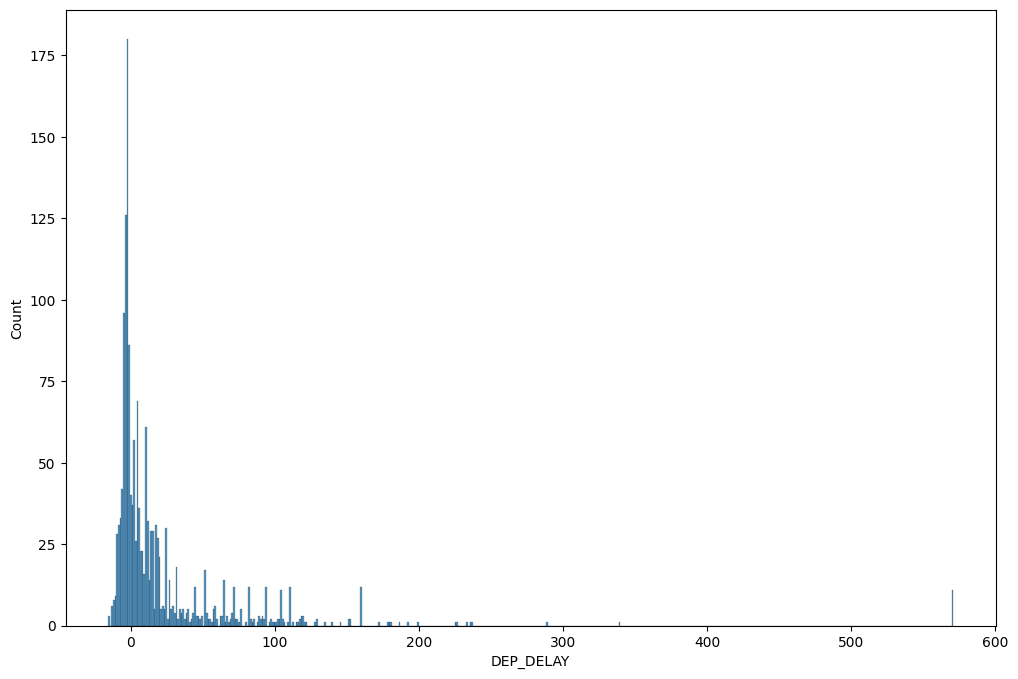

In [ ]:
data= flights_data.loc[(flights_data['ROUTE'] =="DFW-SFO")]['DEP_DELAY']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

In [ ]:
# these show that the null entries for depature delay can be replaced by the median value forthe same route

In [ ]:
# investigating arrival delay
flights_data.loc[flights_data['ARR_DELAY']==0]

,FL_DATE,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DESTINATION,DEST_CITY_NAME,DEP_DELAY,ARR_DELAY,CANCELLED,AIR_TIME,DISTANCE,OCCUPANCY_RATE,ROUTE
97,2019-03-02,WN,N966WN,3468,14679,SAN,"San Diego, CA",14893,SMF,"Sacramento, CA",2.000,0.000,0.000,72.000,480.000,0.870,SAN-SMF
109,2019-03-02,WN,N924WN,3112,14683,SAT,"San Antonio, TX",10693,BNA,"Nashville, TN",-2.000,0.000,0.000,107.000,822.000,0.750,SAT-BNA
144,2019-03-02,WN,N8562Z,4431,14730,SDF,"Louisville, KY",12889,LAS,"Las Vegas, NV",-1.000,0.000,0.000,242.000,1624.000,0.340,SDF-LAS
455,2019-03-02,WN,N293WN,3656,15304,TPA,"Tampa, FL",10599,BHM,"Birmingham, AL",2.000,0.000,0.000,76.000,459.000,0.860,TPA-BHM
458,2019-03-02,WN,N7865A,2596,15304,TPA,"Tampa, FL",10693,BNA,"Nashville, TN",-4.000,0.000,0.000,97.000,612.000,0.660,TPA-BNA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915420,3/8/19,AA,N192AN,1404,13303,MIA,"Miami, FL",14100,PHL,"Philadelphia, PA",-3.000,0.000,0.000,NaN,1013,0.793,MIA-PHL
1915421,3/9/19,AA,N384AA,1404,13303,MIA,"Miami, FL",14100,PHL,"Philadelphia, PA",-7.000,0.000,0.000,Two,1013,0.478,MIA-PHL
1915426,3/14/19,AA,N394AN,1404,13303,MIA,"Miami, FL",14100,PHL,"Philadelphia, PA",13.000,0.000,0.000,NaN,1013,0.786,MIA-PHL
1915593,3/29/19,AA,N871NN,1421,10140,ABQ,"Albuquerque, NM",11298,DFW,"Dallas/Fort Worth, TX",3.000,0.000,0.000,$$$,569,0.585,ABQ-DFW


<Axes: xlabel='ARR_DELAY', ylabel='Count'>

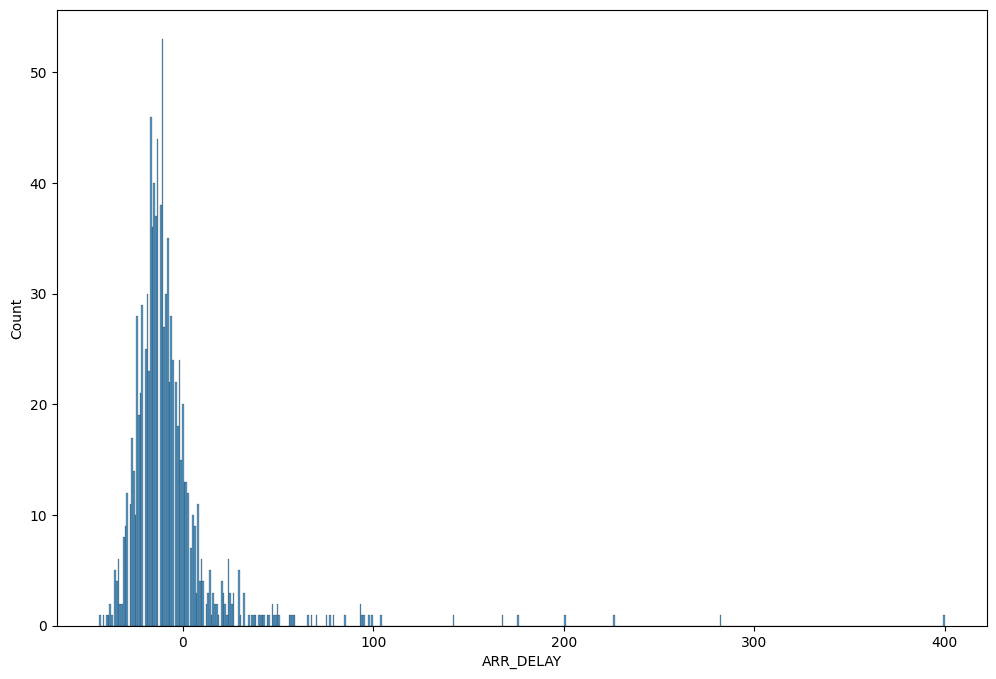

In [ ]:
# randomly selecting routes to see distribution of arrival delay time
data= flights_data.loc[(flights_data['ROUTE'] =="RIC-ATL")]['ARR_DELAY']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

<Axes: xlabel='ARR_DELAY', ylabel='Count'>

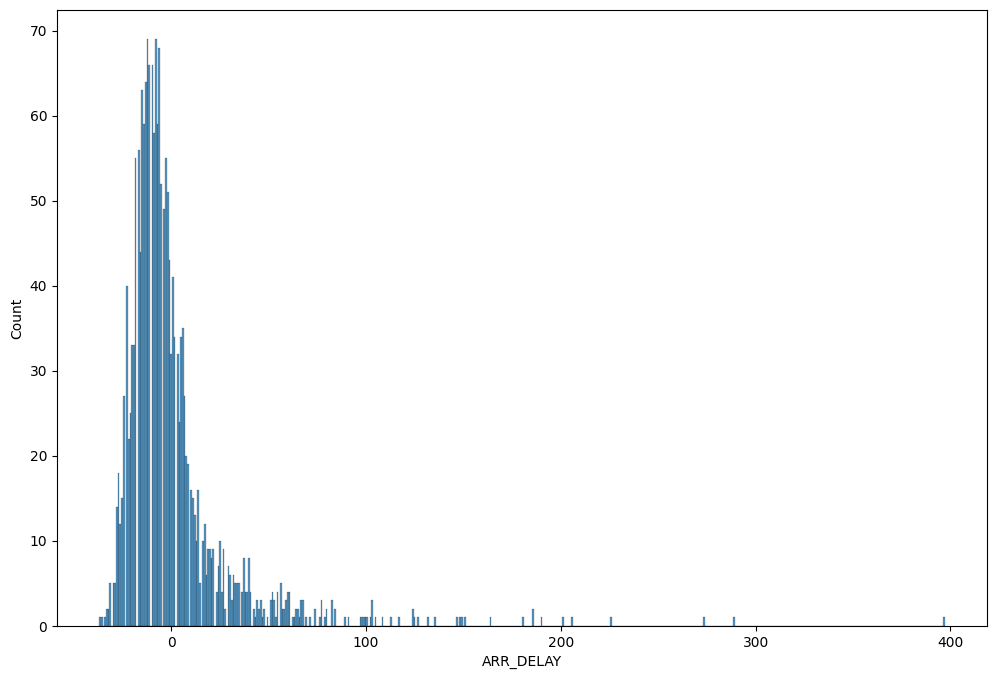

In [ ]:
data= flights_data.loc[(flights_data['ROUTE'] =="PHX-DEN")]['ARR_DELAY']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

<Axes: xlabel='ARR_DELAY', ylabel='Count'>

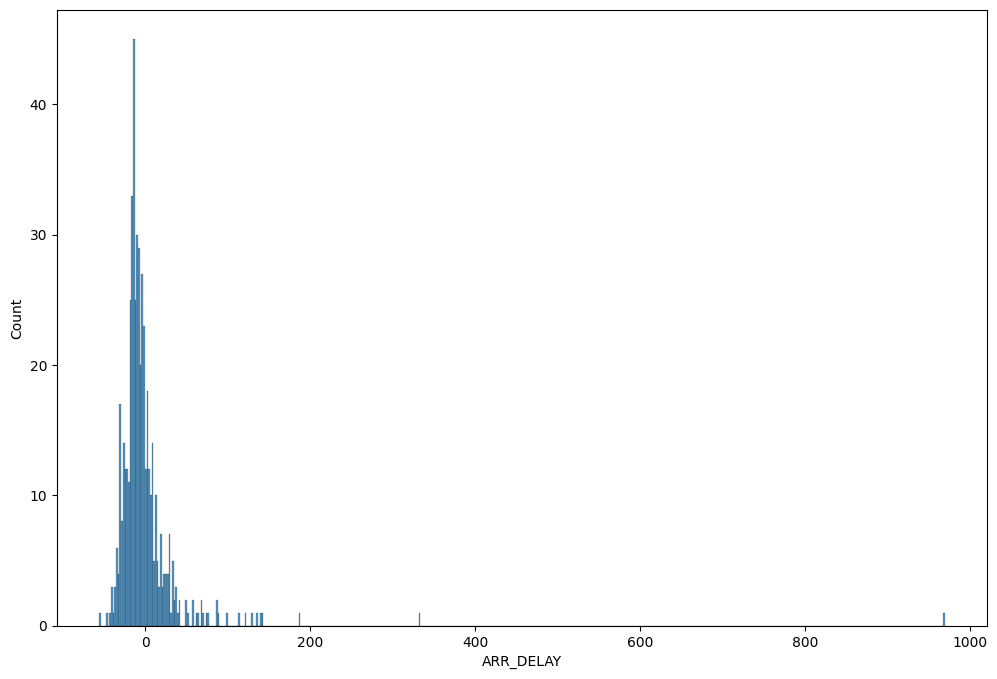

In [ ]:
data= flights_data.loc[(flights_data['ROUTE'] =="MDT-CLT")]['ARR_DELAY']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

In [ ]:
# these show that the null entries for arrival delay can be replaced by the median value for the same route

<Axes: xlabel='OCCUPANCY_RATE', ylabel='Count'>

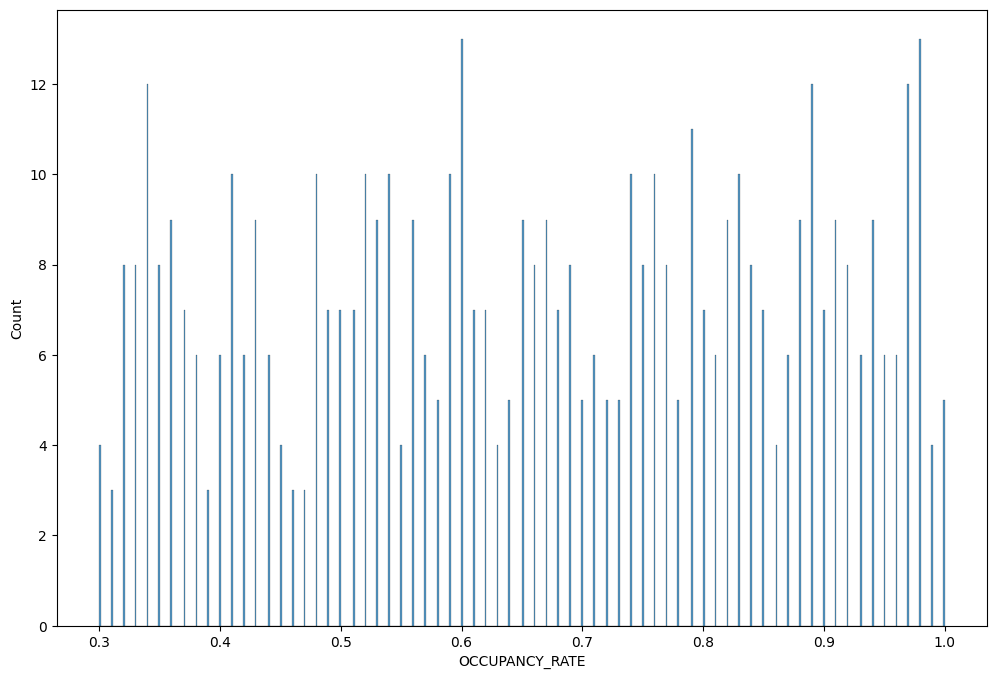

In [ ]:
# investigating occupation rate
data= flights_data.loc[(flights_data['ROUTE'] =="MDT-CLT")]['OCCUPANCY_RATE']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

<Axes: xlabel='OCCUPANCY_RATE', ylabel='Count'>

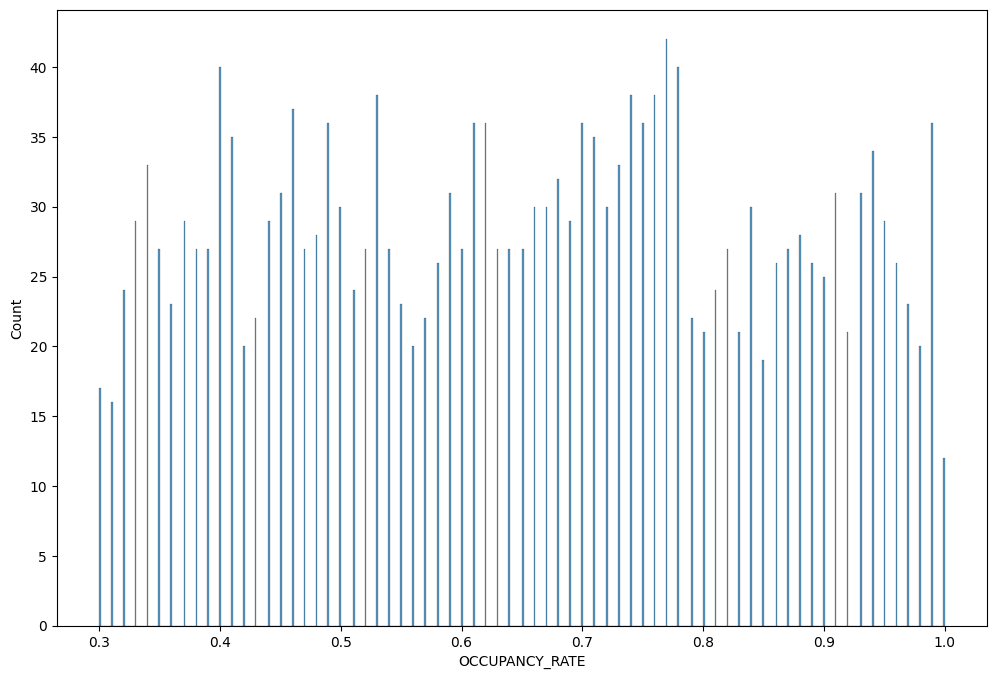

In [ ]:
data= flights_data.loc[(flights_data['ROUTE'] =="PHX-DEN")]['OCCUPANCY_RATE']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

<Axes: xlabel='OCCUPANCY_RATE', ylabel='Count'>

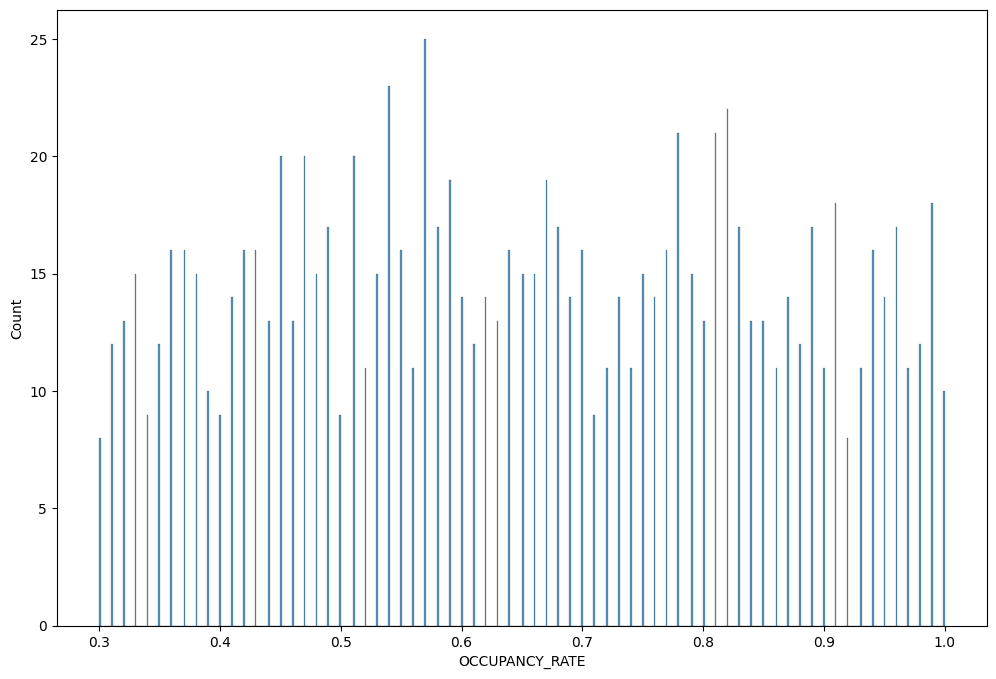

In [ ]:
data= flights_data.loc[(flights_data['ROUTE'] =="RIC-ATL")]['OCCUPANCY_RATE']

plt.figure(figsize=(12, 8))
sns.histplot(data,bins=500)

In [ ]:
# these show that the null entries for occupation rate should be dropped as they can't be replaced by a good representation
# It should be noted that the number of missing occupation rate data is small


**Data Quality Issue 3: Missing data in flights dataset**:

These columns in the flights dataset have null values TAIL_NUM, DEP_DELAY, ARR_DELAY, AIR_TIME, DISTANCE, and OCCUPANCY_RATE.

TAIL_NUM, and OCCUPANCY_RATE are very imoprtant to our calculations, and artificial values cant be created for null values in these columns so we have to drop them

DEP_DELAY, ARR_DELAY, and DISTANCE are also very imoprtant to our calculations, and artificial values would be created for null values in these columns

Null values from the AIR_TIME column would not be dropped becasue they are not useful for our caculation. Dropping these values might result in a loss of data

**Rectifing missing data in flights dataset**

The issue of missing data in the distance column has been rectified as all missing and erroneous records have been replaced.

others are rectified below.

In [ ]:
def flight_delay_cleaner (flight_data):
    '''
        Replaces missing data in arrival and depature column with appropraite median
        drop remaining null values after replacing missing ones
    '''

    median_arr_delay_by_route = flight_data.groupby('ROUTE')['ARR_DELAY'].transform('median')

    # Fill NaN values in 'arr_delay' with the corresponding median for the route
    flight_data['ARR_DELAY'].fillna(median_arr_delay_by_route, inplace=True)


    median_dep_delay_by_route = flight_data.groupby('ROUTE')['DEP_DELAY'].transform('median')

    # Fill NaN values in 'dep_delay' with the corresponding median for the route
    flight_data['DEP_DELAY'].fillna(median_dep_delay_by_route, inplace=True)

    flight_data.dropna(subset=['DEP_DELAY', 'ARR_DELAY'], inplace=True)
    flight_data.reset_index(drop=True, inplace=True)


    return flight_data

In [ ]:
# investigating cancelled flight data
flights_data['CANCELLED'].unique()

array([0., 1.])

In [ ]:
#Its in good condition

**Complete flight data cleaning function is presented next**

In [ ]:
def flight_data_cleaner (flight_data):
    '''
        Returnes clean flight data having:
            Dropped duplicates
            Removed cancelled flights
            Removed null fields for TAIL_NUM, and OCCUPANCY_RATE
            Cleaned FL_DATE, DEP_DELAY, ARR_DELAY, and DISTANCE

        Parameters: flight_data (dataframe)
        Returns: cleaned_flight_data (dataframe)

    '''
    #drop duplicates
    flight_data = flight_data.drop_duplicates()


    # Remove cancelled flights
    cleaned_flight_data = flight_data[flight_data['CANCELLED'] == 0].reset_index(drop=True)


    # Remove null fields for TAIL_NUM, and OCCUPANCY_RATE
    cleaned_flight_data.dropna(subset=['TAIL_NUM', 'OCCUPANCY_RATE'], inplace=True)
    cleaned_flight_data.reset_index(drop=True, inplace=True)

    #Clean DISTANCE
    cleaned_flight_data= flight_distance_cleaner(cleaned_flight_data)

    #Clean FL_DATE
    cleaned_flight_data= flight_date_converter(cleaned_flight_data)

    #Clean DEP_DELAY and ARR_DELAY
    cleaned_flight_data= flight_delay_cleaner(cleaned_flight_data)

    return cleaned_flight_data


In [ ]:
tickets_data.head()

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,736.0,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,570.0,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,564.0,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,345.0,LGA
4,201912723509,2019,1,ABI,US,TX,Texas,0.000,MQ,1.000,309.0,MGM


In [ ]:
tickets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1167285 entries, 0 to 1167284
Data columns (total 12 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   ITIN_ID            1167285 non-null  int64  
 1   YEAR               1167285 non-null  int64  
 2   QUARTER            1167285 non-null  int64  
 3   ORIGIN             1167285 non-null  object 
 4   ORIGIN_COUNTRY     1167285 non-null  object 
 5   ORIGIN_STATE_ABR   1167285 non-null  object 
 6   ORIGIN_STATE_NM    1167285 non-null  object 
 7   ROUNDTRIP          1167285 non-null  float64
 8   REPORTING_CARRIER  1167285 non-null  object 
 9   PASSENGERS         1165308 non-null  float64
 10  ITIN_FARE          1166325 non-null  object 
 11  DESTINATION        1167285 non-null  object 
dtypes: float64(2), int64(3), object(7)
memory usage: 106.9+ MB


**Data Quality Issue 4: Wrong data type in tickets data set**:

The ITIN_FARE column has a wrong data type. This has to be converted to the float data type as it is very important in our calculations

In [ ]:
tickets_data.isna().sum()

ITIN_ID                 0
YEAR                    0
QUARTER                 0
ORIGIN                  0
ORIGIN_COUNTRY          0
ORIGIN_STATE_ABR        0
ORIGIN_STATE_NM         0
ROUNDTRIP               0
REPORTING_CARRIER       0
PASSENGERS           1977
ITIN_FARE             960
DESTINATION             0
dtype: int64

**Data Quality Issue 4: Missing data in tickets dataset**:

These columns in the tickets dataset have null values PASSENGERS and ITIN_FARE.

ITIN_FARE is very imoprtant to our calculations, and artificial values cant be created for null values in this columns so we have to drop them

Null values from the PASSENGERS column would not be dropped becasue they are not useful for our caculation. Dropping these values might result in a loss of data

**Rectifing data quality issues in tickets dataset**

In [ ]:

non_float = tickets_data['ITIN_FARE'].str.match(r'^[-+]?\d*\.?\d+$')
non_string=tickets_data.loc[~(non_float.fillna(True)),'ITIN_FARE']

non_string


1730         820$$$
3105          200 $
3473         820$$$
3565          200 $
4674       $ 100.00
             ...   
1166107       200 $
1166242    $ 100.00
1166247    $ 100.00
1166333      820$$$
1166484       200 $
Name: ITIN_FARE, Length: 3176, dtype: object

In [ ]:
#check if its only dollar signs, numbers, empty spaces, and full stops contained in non converteable entries
error_pattern = r'^[0-9$ .]+$'
non_string.str.match(error_pattern).sum()


3176

In [ ]:
# sum is same as length of non_string series so only dollar signs and empty spaces need to removed

In [ ]:
# investigating missing values
# number of missing values are small compared to whole dataset and can not be easily replaced with artificial values
#they would be dropped

In [ ]:
#Ensuring roundtrip column is appropraite
tickets_data['ROUNDTRIP'].unique()

array([1., 0.])

In [ ]:
def ticket_data_cleaner (ticket_data):
    '''
        Returnes clean ticket data having:
            Dropped duplicates
            Removed non round trips
            Removed null fields for ITIN_FARE
            Cleaned ITIN_FARE

        Parameters: ticket_data (dataframe)
        Returns: cleaned_ticket_data (dataframe)

    '''
    #drop duplicates
    ticket_data = ticket_data.drop_duplicates()


    # Remove non round trips
    cleaned_ticket_data = ticket_data[ticket_data['ROUNDTRIP'] == 1].reset_index(drop=True)


    # Remove null fields for ITIN_FARE
    cleaned_ticket_data.dropna(subset=['ITIN_FARE'], inplace=True)
    cleaned_ticket_data.reset_index(drop=True, inplace=True)

    #Clean ITIN_FARE

    # replace $ and " " with empty string
    cleaned_ticket_data['ITIN_FARE']= cleaned_ticket_data['ITIN_FARE'].replace({'\$': '', ' ': ''}, regex=True)

    # convert ITIN_FARE to correct data type
    cleaned_ticket_data['ITIN_FARE'] = cleaned_ticket_data['ITIN_FARE'].astype(float)


    return cleaned_ticket_data

In [ ]:
airport_codes_data.head(100)

,TYPE,NAME,ELEVATION_FT,CONTINENT,ISO_COUNTRY,MUNICIPALITY,IATA_CODE,COORDINATES
0,heliport,Total Rf Heliport,11.000,NaN,US,Bensalem,NaN,"-74.93360137939453, 40.07080078125"
1,small_airport,Aero B Ranch Airport,3435.000,NaN,US,Leoti,NaN,"-101.473911, 38.704022"
2,small_airport,Lowell Field,450.000,NaN,US,Anchor Point,NaN,"-151.695999146, 59.94919968"
3,small_airport,Epps Airpark,820.000,NaN,US,Harvest,NaN,"-86.77030181884766, 34.86479949951172"
4,closed,Newport Hospital & Clinic Heliport,237.000,NaN,US,Newport,NaN,"-91.254898, 35.6087"
...,...,...,...,...,...,...,...,...
95,heliport,Flow Through Terminal Heliport,736.000,NaN,US,Flint,NaN,"-83.67970275878906, 43.04949951171875"
96,seaplane_base,Barnes Seaplane Base,1358.000,NaN,US,Cook,NaN,"-92.55740356445312, 47.899600982666016"
97,heliport,Highway Patrol Troop C Headquarters Heliport,615.000,NaN,US,Town and Country,NaN,"-90.48429870605469, 38.641700744628906"
98,small_airport,Crystal Lakes Resort Airport,3141.000,NaN,US,Fortine,NaN,"-114.87999725341797, 48.789100646972656"


In [ ]:
airport_codes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55369 entries, 0 to 55368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          55369 non-null  object 
 1   NAME          55369 non-null  object 
 2   ELEVATION_FT  48354 non-null  float64
 3   CONTINENT     27526 non-null  object 
 4   ISO_COUNTRY   55122 non-null  object 
 5   MUNICIPALITY  49663 non-null  object 
 6   IATA_CODE     9182 non-null   object 
 7   COORDINATES   55369 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.4+ MB


In [ ]:
airport_codes_data.isna().sum()

TYPE                0
NAME                0
ELEVATION_FT     7015
CONTINENT       27843
ISO_COUNTRY       247
MUNICIPALITY     5706
IATA_CODE       46187
COORDINATES         0
dtype: int64

**Data Quality Issue 5: Missing data in Airport Codes dataset**:

These columns in the tickets dataset have null values ELEVATION_FT, CONTINENT, ISO_COUNTRY, MUNICIPALITY, IATA_CODE.

IATA_CODE is very imoprtant to our calculations, and artificial values cant be created for null values in this columns so we have to drop them

Null values from the ELEVATION_FT, CONTINENT, ISO_COUNTRY, and MUNICIPALITY, columns would not be dropped becasue they are not useful for our caculation. Dropping these values might result in a loss of data

In [ ]:
# enusre IATA_CODE only contains three upper case letter
mask = airport_codes_data['IATA_CODE'].str.match(r'^[A-Z]{3}$')


non_IATA_CODE_pattern = airport_codes_data.loc[~(mask.fillna(True)), 'IATA_CODE']
non_IATA_CODE_pattern

16142    TR7
18962      -
37302    O62
41197    SB2
41247      0
        ... 
47119      0
47165      0
47276      0
47337      0
48351    BR-
Name: IATA_CODE, Length: 85, dtype: object

**Data Quality Issue 5: Some IATA_CODE entries are incorrect**:
A few IATA_code entries are incorrect they would be dropped.

In [ ]:
#Resolving incorrect entries


In [ ]:
def IATA_CODE_cleaner (airport_code_data):

    '''
        This function drops incorrect IATA_CODE entries
    '''

    mask = airport_code_data['IATA_CODE'].str.match(r'^[A-Z]{3}$')


    non_IATA_CODE_pattern = airport_code_data.loc[~(mask.fillna(True)), 'IATA_CODE']
    non_IATA_CODE_pattern=non_IATA_CODE_pattern.unique()


    airport_code_data['IATA_CODE']=airport_code_data['IATA_CODE'][~airport_code_data['IATA_CODE'].isin(non_IATA_CODE_pattern)].reset_index(drop=True)

    return airport_code_data


In [ ]:
# ensuring the type column is clean

airport_codes_data['TYPE'].unique()

array(['heliport', 'small_airport', 'closed', 'seaplane_base',
       'balloonport', 'medium_airport', 'large_airport'], dtype=object)

In [ ]:
# Resolving all data quality issues with airport codes dataset below

In [ ]:
def airport_code_data_cleaner (airport_code_data):
    '''
        Returnes clean airport code data having:
            Dropped duplicates
            Removed non medium or large airports
            Cleaned IATA_CODE
            Removed null fields of IATA_CODE


        Parameters: airport_code_data (dataframe)
        Returns: cleaned_airport_code_data (dataframe)

    '''



    # Remove non medium or non large airports
    cleaned_airport_code_data = airport_code_data[airport_code_data['TYPE'].isin(['medium_airport', 'large_airport'])].reset_index(drop=True)


    # Cleaned IATA_CODE
    cleaned_airport_code_data= IATA_CODE_cleaner (cleaned_airport_code_data)

    #Removed null fields of IATA_CODE
    cleaned_airport_code_data.dropna(subset=['IATA_CODE'], inplace=True)
    cleaned_airport_code_data.reset_index(drop=True, inplace=True)


    return cleaned_airport_code_data

**Addressing all data quality issues identified**

In [ ]:
cleaned_flights_data = flight_data_cleaner (flights_data)

In [ ]:
cleaned_tickets_data = ticket_data_cleaner (tickets_data)

In [ ]:
cleaned_airport_codes_data = airport_code_data_cleaner (airport_codes_data)

In [ ]:
#shape of datasets before cleaning
print(flights_data.shape,tickets_data.shape,airport_codes_data.shape)

(1915886, 17) (1167285, 12) (55369, 8)


In [ ]:
#shape of dataset after cleaning
print(cleaned_flights_data.shape,cleaned_tickets_data.shape,cleaned_airport_codes_data.shape)

(1859824, 17) (660585, 12) (4459, 8)


# Data Munging

In [ ]:
def round_trip_dataset_creation (flight_data, airport_code_data ):
    '''
        Merges flight and airport data together
        Uses self join to create round trip dataframe

        New Field Metadata

            'INITIAL_ORIGIN': Shows origin of first flight in round trip
            'INITIAL_DESTINATION': Shows destination of first flight in round trip
            'FINAL_ORIGIN': Shows origin of second flight in round trip
            'FINAL_DESTINATION': Shows destination of second flight in round trip
            'INITIAL_DEP_DELAY': Shows first depature delay for round trip
            'INITIAL_ARR_DELAY': Shows first arrival delay for round trip
            'FINAL_DEP_DELAY': Shows second depature delay for round trip
            'INITIAL_DISTANCE': Shows first distance of round trip
            'FINAL_DISTANCE': Shows second distance of round trip
            'DISTANCE': Shows distance of round trip
            'INITIAL_OCCUPANCY_RATE': Shows first occupation rate for round trip
            'FINAL_OCCUPANCY_RATE': Shows second occupation rate for round trip
            'INITIAL_TYPE': Shows first landing airport type for round trip
            'FINAL_TYPE': Shows second landing airport type for round trip
            'RT-id': Roundtrip identity column, designates the route of roudntrip
    '''

    # Merge the flights and airport DataFrames
    merged_flight_airport_data = cleaned_flights_data.merge(
        cleaned_airport_codes_data,
        left_on='ORIGIN',
        right_on='IATA_CODE'
    )

    new_fields = list(cleaned_flights_data.columns) + ['TYPE']
    merged_flight_airport_data = merged_flight_airport_data[new_fields]

    #Use self join to create round trip dataframe
    conn = sqlite3.connect(':memory:')

    merged_flight_airport_data.to_sql('merged_flight_airport_data', conn, if_exists='replace')

    query = """
    SELECT
        t1.FL_DATE,
        t1.TAIL_NUM,
        t1.ORIGIN AS INITIAL_ORIGIN,
        t1.DESTINATION AS INITIAL_DESTINATION,
        t2.ORIGIN AS FINAL_ORIGIN,
        t2.DESTINATION AS FINAL_DESTINATION,
        t1.DEP_DELAY AS INITIAL_DEP_DELAY,
        t1.ARR_DELAY AS INITIAL_ARR_DELAY,
        t2.DEP_DELAY AS FINAL_DEP_DELAY,
        t2.ARR_DELAY AS FINAL_ARR_DELAY,
        t1.DISTANCE AS INITIAL_DISTANCE,
        t2.DISTANCE AS FINAL_DISTANCE,
        t1.OCCUPANCY_RATE AS INITIAL_OCCUPANCY_RATE,
        t2.OCCUPANCY_RATE AS FINAL_OCCUPANCY_RATE,
        t1.TYPE AS INITIAL_TYPE,
        t2.TYPE AS FINAL_TYPE
    FROM
        merged_flight_airport_data t1
    INNER JOIN
        merged_flight_airport_data t2
    ON
        t2.FL_DATE = t1.FL_DATE
        AND t2.TAIL_NUM = t1.TAIL_NUM
        AND t2.ORIGIN = t1.DESTINATION
        AND t2.DESTINATION = t1.ORIGIN
        AND t2.ORIGIN != t1.ORIGIN
        AND t2.DESTINATION != t1.DESTINATION
        AND t2.ORIGIN < t1.ORIGIN
"""

    Roundtrip_flights_data = pd.read_sql_query(query, conn)


    conn.close()

    # create round trip id column
    Roundtrip_flights_data['RT-id'] = Roundtrip_flights_data['INITIAL_ORIGIN'] + '-' + Roundtrip_flights_data['INITIAL_DESTINATION']

    #ensure that only entries where distance entered for initial and final flight are same are recorded (only 3 entries lost)
    Roundtrip_flights_data=Roundtrip_flights_data.loc[(Roundtrip_flights_data['INITIAL_DISTANCE']==Roundtrip_flights_data['FINAL_DISTANCE'])]
    Roundtrip_flights_data['DISTANCE']=Roundtrip_flights_data['INITIAL_DISTANCE']*2
    Roundtrip_flights_data = Roundtrip_flights_data.drop(columns=['INITIAL_DISTANCE','FINAL_DISTANCE'])
    Roundtrip_flights_data.reset_index(drop=True, inplace=True)
    return(Roundtrip_flights_data)

In [ ]:
Roundtrip_flights_data=round_trip_dataset_creation (cleaned_flights_data, cleaned_airport_codes_data )

In [ ]:
Roundtrip_flights_data.head()

,FL_DATE,TAIL_NUM,INITIAL_ORIGIN,INITIAL_DESTINATION,FINAL_ORIGIN,FINAL_DESTINATION,INITIAL_DEP_DELAY,INITIAL_ARR_DELAY,FINAL_DEP_DELAY,FINAL_ARR_DELAY,INITIAL_OCCUPANCY_RATE,FINAL_OCCUPANCY_RATE,INITIAL_TYPE,FINAL_TYPE,RT-id,DISTANCE
0,2019-03-02,N7832A,RSW,DAL,DAL,RSW,0.000,-17.000,-8.000,-10.000,0.620,0.580,large_airport,large_airport,RSW-DAL,2010.000
1,2019-03-02,N8730Q,RSW,ROC,ROC,RSW,-1.000,11.000,-3.000,-19.000,0.560,0.950,large_airport,large_airport,RSW-ROC,2332.000
2,2019-03-09,N781WN,RSW,CMH,CMH,RSW,7.000,8.000,13.000,11.000,0.690,0.870,large_airport,large_airport,RSW-CMH,1860.000
3,2019-03-09,N8579Z,RSW,DAL,DAL,RSW,211.000,192.000,40.000,134.000,0.820,0.620,large_airport,large_airport,RSW-DAL,2010.000
4,2019-03-09,N8699A,RSW,IND,IND,RSW,20.000,22.000,-6.000,-21.000,0.940,0.960,large_airport,large_airport,RSW-IND,1890.000


In [ ]:
Roundtrip_flights_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 519444 entries, 0 to 519443
Data columns (total 16 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   FL_DATE                 519444 non-null  object 
 1   TAIL_NUM                519444 non-null  object 
 2   INITIAL_ORIGIN          519444 non-null  object 
 3   INITIAL_DESTINATION     519444 non-null  object 
 4   FINAL_ORIGIN            519444 non-null  object 
 5   FINAL_DESTINATION       519444 non-null  object 
 6   INITIAL_DEP_DELAY       519444 non-null  float64
 7   INITIAL_ARR_DELAY       519444 non-null  float64
 8   FINAL_DEP_DELAY         519444 non-null  float64
 9   FINAL_ARR_DELAY         519444 non-null  float64
 10  INITIAL_OCCUPANCY_RATE  519444 non-null  float64
 11  FINAL_OCCUPANCY_RATE    519444 non-null  float64
 12  INITIAL_TYPE            519444 non-null  object 
 13  FINAL_TYPE              519444 non-null  object 
 14  RT-id               

In [ ]:
Roundtrip_flights_data.head()

,FL_DATE,TAIL_NUM,INITIAL_ORIGIN,INITIAL_DESTINATION,FINAL_ORIGIN,FINAL_DESTINATION,INITIAL_DEP_DELAY,INITIAL_ARR_DELAY,FINAL_DEP_DELAY,FINAL_ARR_DELAY,INITIAL_OCCUPANCY_RATE,FINAL_OCCUPANCY_RATE,INITIAL_TYPE,FINAL_TYPE,RT-id,DISTANCE
0,2019-03-02,N7832A,RSW,DAL,DAL,RSW,0.000,-17.000,-8.000,-10.000,0.620,0.580,large_airport,large_airport,RSW-DAL,2010.000
1,2019-03-02,N8730Q,RSW,ROC,ROC,RSW,-1.000,11.000,-3.000,-19.000,0.560,0.950,large_airport,large_airport,RSW-ROC,2332.000
2,2019-03-09,N781WN,RSW,CMH,CMH,RSW,7.000,8.000,13.000,11.000,0.690,0.870,large_airport,large_airport,RSW-CMH,1860.000
3,2019-03-09,N8579Z,RSW,DAL,DAL,RSW,211.000,192.000,40.000,134.000,0.820,0.620,large_airport,large_airport,RSW-DAL,2010.000
4,2019-03-09,N8699A,RSW,IND,IND,RSW,20.000,22.000,-6.000,-21.000,0.940,0.960,large_airport,large_airport,RSW-IND,1890.000


In [ ]:
cleaned_tickets_data.head()

,ITIN_ID,YEAR,QUARTER,ORIGIN,ORIGIN_COUNTRY,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,ROUNDTRIP,REPORTING_CARRIER,PASSENGERS,ITIN_FARE,DESTINATION
0,201912723049,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,736.000,DAB
1,201912723085,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,570.000,COS
2,201912723491,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,564.000,MCO
3,201912723428,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,345.000,LGA
4,201912723337,2019,1,ABI,US,TX,Texas,1.000,MQ,1.000,1647.000,JAX


In [ ]:
def avg_ticket_fare (ticket_data):
    '''
        Creates new dataframe showing average ticket fare for each roundtrip

        New Field Metadata

            'AVG_ITIN_FARE': Average Itinerary Fare Per Person column, designates the route of roudntrip
    '''
    # create round trip id
    ticket_data['RT-id'] = ticket_data['ORIGIN'] + '-' + ticket_data['DESTINATION']

    # calculated round trip average ticket fare
    avg_ITIN_FARE = ticket_data.groupby('RT-id')['ITIN_FARE'].mean().reset_index()
    avg_ITIN_FARE= avg_ITIN_FARE.rename(columns = {'ITIN_FARE':'AVG_ITIN_FARE'})




    #create new dataframe showing average ticket fare and round trip id
    new_tickets_data = ticket_data.merge(avg_ITIN_FARE, on='RT-id', how='inner')[[ 'AVG_ITIN_FARE','RT-id']]

    new_tickets_data=new_tickets_data.drop_duplicates().reset_index(drop=True)

    return new_tickets_data

In [ ]:
new_tickets_data = avg_ticket_fare (cleaned_tickets_data)

In [ ]:
new_tickets_data

,AVG_ITIN_FARE,RT-id
0,661.500,ABI-DAB
1,600.500,ABI-COS
2,640.400,ABI-MCO
3,575.778,ABI-LGA
4,528.286,ABI-JAX
...,...,...
40274,586.000,XNA-DHN
40275,1364.000,XNA-LNK
40276,461.000,YKM-XNA
40277,692.000,YUM-ALB


In [ ]:
def flight_fare_data(flight_data, ticket_data):
    """
    Creates new data frame by inner joining flight_data to ticket_data
    """
    flight_fare_data = flight_data.merge(ticket_data,on=['RT-id'],how='inner')
    return flight_fare_data

In [ ]:
Roundtrip_flights_fare_data=flight_fare_data(Roundtrip_flights_data, new_tickets_data)

In [ ]:
Roundtrip_flights_fare_data.head()

,FL_DATE,TAIL_NUM,INITIAL_ORIGIN,INITIAL_DESTINATION,FINAL_ORIGIN,FINAL_DESTINATION,INITIAL_DEP_DELAY,INITIAL_ARR_DELAY,FINAL_DEP_DELAY,FINAL_ARR_DELAY,INITIAL_OCCUPANCY_RATE,FINAL_OCCUPANCY_RATE,INITIAL_TYPE,FINAL_TYPE,RT-id,DISTANCE,AVG_ITIN_FARE
0,2019-03-02,N7832A,RSW,DAL,DAL,RSW,0.000,-17.000,-8.000,-10.000,0.620,0.580,large_airport,large_airport,RSW-DAL,2010.000,405.545
1,2019-03-09,N8579Z,RSW,DAL,DAL,RSW,211.000,192.000,40.000,134.000,0.820,0.620,large_airport,large_airport,RSW-DAL,2010.000,405.545
2,2019-03-28,N7883A,RSW,DAL,DAL,RSW,-1.000,-18.000,-5.000,-22.000,0.920,0.930,large_airport,large_airport,RSW-DAL,2010.000,405.545
3,2019-03-29,N413WN,RSW,DAL,DAL,RSW,-4.000,-35.000,-5.000,-25.000,0.820,0.690,large_airport,large_airport,RSW-DAL,2010.000,405.545
4,2019-03-20,N936WN,RSW,DAL,DAL,RSW,-3.000,-8.000,7.000,-8.000,0.840,0.500,large_airport,large_airport,RSW-DAL,2010.000,405.545


In [ ]:
def trip_average_calculator(flight_data):
    '''
        This returns a dataframe containing key average metrics for the roundtrips

        New Field Metadata

            'ROUND_TRIP_COUNT': Shows number of times a round trip was taken by passengers
            'AVG_PEN_INITIAL_DEP_DELAY': Shows average initial depature delay penalizable for round trip
            'AVG_PEN_INITIAL_ARR_DELAY': Shows average initial arrival delay penalizable for round trip
            'AVG_PEN_FINAL_DEP_DELAY': Shows average final depature delay penalizable for round trip
            'AVG_PEN_FINAL_ARR_DELAY': Shows average final arrival delay penalizable for round trip
            'AVG_OCCUPANCY_RATE': Shows average occupation rate for round trip

    '''

    # add cumber of round trips in Q12019
    flight_data['ROUND_TRIP_COUNT'] = flight_data.groupby('RT-id')['RT-id'].transform('count')

    #generate average penalizable delay times

    delay_columns = ['INITIAL_DEP_DELAY', 'INITIAL_ARR_DELAY', 'FINAL_DEP_DELAY', 'FINAL_ARR_DELAY']

    flight_data[delay_columns] = np.maximum(flight_data[delay_columns] - 15, 0)

    flight_data['AVG_PEN_INITIAL_DEP_DELAY'] = flight_data.groupby('RT-id')['INITIAL_DEP_DELAY'].transform('mean')
    flight_data['AVG_PEN_INITIAL_ARR_DELAY'] = flight_data.groupby('RT-id')['INITIAL_ARR_DELAY'].transform('mean')
    flight_data['AVG_PEN_FINAL_DEP_DELAY'] = flight_data.groupby('RT-id')['FINAL_DEP_DELAY'].transform('mean')
    flight_data['AVG_PEN_FINAL_ARR_DELAY'] = flight_data.groupby('RT-id')['FINAL_ARR_DELAY'].transform('mean')

    # generate average occupation rate for found trip
    flight_data['AVG_OCCUPANCY_PER_TRIP'] = (flight_data['INITIAL_OCCUPANCY_RATE'] + flight_data['FINAL_OCCUPANCY_RATE']) / 2
    flight_data['AVG_OCCUPANCY_RATE'] = flight_data.groupby('RT-id')['AVG_OCCUPANCY_PER_TRIP'].transform('mean')

    Roundtrip_flight_finance=flight_data[['RT-id','INITIAL_TYPE','FINAL_TYPE','DISTANCE','AVG_ITIN_FARE','ROUND_TRIP_COUNT','AVG_PEN_INITIAL_DEP_DELAY','AVG_PEN_INITIAL_ARR_DELAY','AVG_PEN_FINAL_DEP_DELAY','AVG_PEN_FINAL_ARR_DELAY','AVG_OCCUPANCY_RATE']]


    Roundtrip_flight_finance=Roundtrip_flight_finance.drop_duplicates().reset_index(drop=True)

    return Roundtrip_flight_finance

In [ ]:
Roundtrip_average_data= trip_average_calculator(Roundtrip_flights_fare_data)

In [ ]:
Roundtrip_average_data

,RT-id,INITIAL_TYPE,FINAL_TYPE,DISTANCE,AVG_ITIN_FARE,ROUND_TRIP_COUNT,AVG_PEN_INITIAL_DEP_DELAY,AVG_PEN_INITIAL_ARR_DELAY,AVG_PEN_FINAL_DEP_DELAY,AVG_PEN_FINAL_ARR_DELAY,AVG_OCCUPANCY_RATE
0,RSW-DAL,large_airport,large_airport,2010.000,405.545,82,11.695,8.451,7.463,8.110,0.632
1,RSW-ROC,large_airport,large_airport,2332.000,467.857,3,60.667,55.667,65.000,60.333,0.652
2,RSW-CMH,large_airport,large_airport,1860.000,262.830,41,17.902,16.707,6.902,7.951,0.667
3,RSW-IND,large_airport,large_airport,1890.000,360.500,69,2.855,1.652,2.391,2.043,0.632
4,RSW-MCI,large_airport,large_airport,2310.000,415.889,2,0.000,0.000,0.000,0.000,0.615
...,...,...,...,...,...,...,...,...,...,...,...
2650,TTN-FLL,medium_airport,large_airport,2052.000,150.750,51,7.608,7.608,11.157,8.490,0.642
2651,TTN-BNA,medium_airport,large_airport,1412.000,50.333,11,17.727,20.273,15.818,10.727,0.637
2652,TTN-RDU,medium_airport,large_airport,746.000,109.444,21,12.619,12.286,11.286,8.667,0.680
2653,CSG-ATL,medium_airport,large_airport,166.000,474.000,276,7.996,8.942,5.594,5.837,0.635


In [ ]:
def flight_finance(flight):
    '''
        Calculates key financial data for round trip

        New Field Metadata

            'REVENUE_PER_FLIGHT': Shows revenue per flight for round trip
            'COST_PER_FLIGHT': Shows cost per flight for round trip
            'PROFIT_PER_FLIGHT': Shows profit per flight for round trip

    '''
    # Constants
    capacity = 200
    round_trip_baggage_fee= 70

    # FOMC = Fuel, Oil, Maintenance, Crew
    FOMC_cost_per_mile = 8

    # DIO = Depreciation, Insurance, Other
    DIO_cost_per_mile = 1.18

    medium_airport_cost = 5000
    large_airport_cost = 10000
    airport_cost_dict = {
    'large_airport': large_airport_cost,
    'medium_airport': medium_airport_cost}

    delay_cost_per_minute = 75


    # Revenue Calculation

    ticket_revenue = flight['AVG_ITIN_FARE'] * flight['AVG_OCCUPANCY_RATE'] * capacity
    baggage_revenue = 0.5 * flight['AVG_OCCUPANCY_RATE'] * capacity * round_trip_baggage_fee
    total_revenue = ticket_revenue + baggage_revenue

    # Calculate cost

    FOMC_cost = FOMC_cost_per_mile * flight['DISTANCE']
    DIO_cost = DIO_cost_per_mile * flight['DISTANCE']


    airport_cost = flight[['INITIAL_TYPE', 'FINAL_TYPE']].map(airport_cost_dict).sum()



    delay_cost = (flight[['AVG_PEN_INITIAL_DEP_DELAY', 'AVG_PEN_INITIAL_ARR_DELAY', 'AVG_PEN_FINAL_DEP_DELAY', 'AVG_PEN_FINAL_ARR_DELAY']].sum() )* delay_cost_per_minute


    total_cost = FOMC_cost + DIO_cost + airport_cost + delay_cost

    # Calculate profit
    profit = total_revenue - total_cost

    # Update the row with calculated values
    flight['REVENUE_PER_FLIGHT'] = total_revenue
    flight['COST_PER_FLIGHT'] = total_cost
    flight['PROFIT_PER_FLIGHT'] = profit

    return flight

In [ ]:
Roundtrip_flight_finance = Roundtrip_average_data.apply(flight_finance, axis=1)

In [ ]:
Roundtrip_flight_finance

,RT-id,INITIAL_TYPE,FINAL_TYPE,DISTANCE,AVG_ITIN_FARE,ROUND_TRIP_COUNT,AVG_PEN_INITIAL_DEP_DELAY,AVG_PEN_INITIAL_ARR_DELAY,AVG_PEN_FINAL_DEP_DELAY,AVG_PEN_FINAL_ARR_DELAY,AVG_OCCUPANCY_RATE,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,PROFIT_PER_FLIGHT
0,RSW-DAL,large_airport,large_airport,2010.000,405.545,82,11.695,8.451,7.463,8.110,0.632,55696.765,41130.763,14566.002
1,RSW-ROC,large_airport,large_airport,2332.000,467.857,3,60.667,55.667,65.000,60.333,0.652,65539.048,59532.760,6006.288
2,RSW-CMH,large_airport,large_airport,1860.000,262.830,41,17.902,16.707,6.902,7.951,0.667,39727.642,40784.556,-1056.915
3,RSW-IND,large_airport,large_airport,1890.000,360.500,69,2.855,1.652,2.391,2.043,0.632,49964.833,38020.852,11943.981
4,RSW-MCI,large_airport,large_airport,2310.000,415.889,2,0.000,0.000,0.000,0.000,0.615,55459.333,41205.800,14253.533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,TTN-FLL,medium_airport,large_airport,2052.000,150.750,51,7.608,7.608,11.157,8.490,0.642,23852.485,36452.066,-12599.581
2651,TTN-BNA,medium_airport,large_airport,1412.000,50.333,11,17.727,20.273,15.818,10.727,0.637,10876.121,32803.069,-21926.948
2652,TTN-RDU,medium_airport,large_airport,746.000,109.444,21,12.619,12.286,11.286,8.667,0.680,19658.201,25212.566,-5554.365
2653,CSG-ATL,medium_airport,large_airport,166.000,474.000,276,7.996,8.942,5.594,5.837,0.635,64630.091,18651.597,45978.493


# Visual Data Narrative

In [ ]:
def bar_chart_plotter(plot_data, x_col, y_col, title, rotation):
    """plots bar chart based on parameters"""
    fig,ax=plt.subplots(figsize=(13,10))
    plt.style.use('ggplot')
    sns.barplot(data =plot_data, x=x_col, y=y_col)
    sns.set(font_scale=2.5)
    plt.xticks(rotation=rotation)
    plt.title(title)

### 1. The 10 busiest round-trip routes in terms of number of round-trip flights in the quarter. Exclude canceled flights when performing the calculation.

In [ ]:
busiest_trips=Roundtrip_flight_finance.sort_values(by='ROUND_TRIP_COUNT', ascending=False)[['RT-id','ROUND_TRIP_COUNT']].head(10).reset_index(drop=True)
busiest_trips

,RT-id,ROUND_TRIP_COUNT
0,SFO-LAX,5444
1,OGG-HNL,5379
2,LGA-BOS,4781
3,ORD-LGA,3830
4,LIH-HNL,2836
5,DCA-BOS,2725
6,KOA-HNL,2712
7,LGA-DCA,2523
8,SFO-SAN,2245
9,LAX-JFK,2190


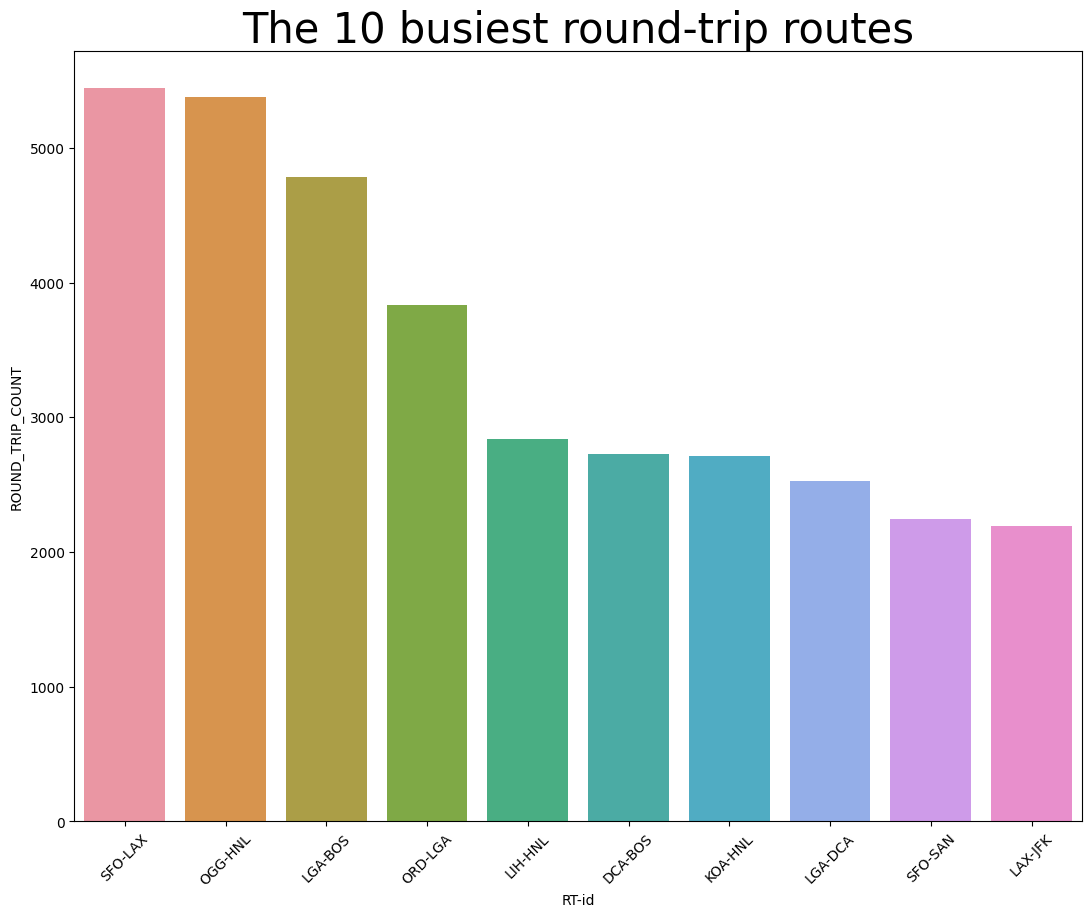

In [ ]:
bar_chart_plotter(busiest_trips, 'RT-id', 'ROUND_TRIP_COUNT', 'The 10 busiest round-trip routes', 45)

### 2. The 10 most profitable round trip routes (without considering the upfront airplane cost) in the quarter. Along with the profit, show total revenue, total cost, summary values of other key components and total round trip flights in the quarter for the top 10 most profitable routes. Exclude canceled flights from these calculations.

In [ ]:
Roundtrip_flight_finance

,RT-id,INITIAL_TYPE,FINAL_TYPE,DISTANCE,AVG_ITIN_FARE,ROUND_TRIP_COUNT,AVG_PEN_INITIAL_DEP_DELAY,AVG_PEN_INITIAL_ARR_DELAY,AVG_PEN_FINAL_DEP_DELAY,AVG_PEN_FINAL_ARR_DELAY,AVG_OCCUPANCY_RATE,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,PROFIT_PER_FLIGHT
0,RSW-DAL,large_airport,large_airport,2010.000,405.545,82,11.695,8.451,7.463,8.110,0.632,55696.765,41130.763,14566.002
1,RSW-ROC,large_airport,large_airport,2332.000,467.857,3,60.667,55.667,65.000,60.333,0.652,65539.048,59532.760,6006.288
2,RSW-CMH,large_airport,large_airport,1860.000,262.830,41,17.902,16.707,6.902,7.951,0.667,39727.642,40784.556,-1056.915
3,RSW-IND,large_airport,large_airport,1890.000,360.500,69,2.855,1.652,2.391,2.043,0.632,49964.833,38020.852,11943.981
4,RSW-MCI,large_airport,large_airport,2310.000,415.889,2,0.000,0.000,0.000,0.000,0.615,55459.333,41205.800,14253.533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,TTN-FLL,medium_airport,large_airport,2052.000,150.750,51,7.608,7.608,11.157,8.490,0.642,23852.485,36452.066,-12599.581
2651,TTN-BNA,medium_airport,large_airport,1412.000,50.333,11,17.727,20.273,15.818,10.727,0.637,10876.121,32803.069,-21926.948
2652,TTN-RDU,medium_airport,large_airport,746.000,109.444,21,12.619,12.286,11.286,8.667,0.680,19658.201,25212.566,-5554.365
2653,CSG-ATL,medium_airport,large_airport,166.000,474.000,276,7.996,8.942,5.594,5.837,0.635,64630.091,18651.597,45978.493


In [ ]:
def total_calculator (flight_data):

    flight_data['TOTAL_REVENUE']=flight_data['REVENUE_PER_FLIGHT']*flight_data['ROUND_TRIP_COUNT']
    flight_data['TOTAL_COST']=flight_data['REVENUE_PER_FLIGHT']*flight_data['ROUND_TRIP_COUNT']
    flight_data['TOTAL_PROFIT']=flight_data['PROFIT_PER_FLIGHT']*flight_data['ROUND_TRIP_COUNT']

    return flight_data

In [ ]:
Total_Roundtrip_Finance = total_calculator (Roundtrip_flight_finance)

In [ ]:
Total_Roundtrip_Finance

,RT-id,INITIAL_TYPE,FINAL_TYPE,DISTANCE,AVG_ITIN_FARE,ROUND_TRIP_COUNT,AVG_PEN_INITIAL_DEP_DELAY,AVG_PEN_INITIAL_ARR_DELAY,AVG_PEN_FINAL_DEP_DELAY,AVG_PEN_FINAL_ARR_DELAY,AVG_OCCUPANCY_RATE,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,PROFIT_PER_FLIGHT,TOTAL_REVENUE,TOTAL_COST,TOTAL_PROFIT
0,RSW-DAL,large_airport,large_airport,2010.000,405.545,82,11.695,8.451,7.463,8.110,0.632,55696.765,41130.763,14566.002,4567134.727,4567134.727,1194412.127
1,RSW-ROC,large_airport,large_airport,2332.000,467.857,3,60.667,55.667,65.000,60.333,0.652,65539.048,59532.760,6006.288,196617.143,196617.143,18018.863
2,RSW-CMH,large_airport,large_airport,1860.000,262.830,41,17.902,16.707,6.902,7.951,0.667,39727.642,40784.556,-1056.915,1628833.302,1628833.302,-43333.498
3,RSW-IND,large_airport,large_airport,1890.000,360.500,69,2.855,1.652,2.391,2.043,0.632,49964.833,38020.852,11943.981,3447573.500,3447573.500,824134.700
4,RSW-MCI,large_airport,large_airport,2310.000,415.889,2,0.000,0.000,0.000,0.000,0.615,55459.333,41205.800,14253.533,110918.667,110918.667,28507.067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2650,TTN-FLL,medium_airport,large_airport,2052.000,150.750,51,7.608,7.608,11.157,8.490,0.642,23852.485,36452.066,-12599.581,1216476.750,1216476.750,-642578.610
2651,TTN-BNA,medium_airport,large_airport,1412.000,50.333,11,17.727,20.273,15.818,10.727,0.637,10876.121,32803.069,-21926.948,119637.333,119637.333,-241196.427
2652,TTN-RDU,medium_airport,large_airport,746.000,109.444,21,12.619,12.286,11.286,8.667,0.680,19658.201,25212.566,-5554.365,412822.222,412822.222,-116641.658
2653,CSG-ATL,medium_airport,large_airport,166.000,474.000,276,7.996,8.942,5.594,5.837,0.635,64630.091,18651.597,45978.493,17837905.000,17837905.000,12690064.120


In [ ]:
most_profitable=Total_Roundtrip_Finance.sort_values(by='TOTAL_PROFIT', ascending=False)[['RT-id','TOTAL_PROFIT','TOTAL_REVENUE','TOTAL_COST','PROFIT_PER_FLIGHT','REVENUE_PER_FLIGHT','COST_PER_FLIGHT','ROUND_TRIP_COUNT']].head(10).reset_index(drop=True)
most_profitable

,RT-id,TOTAL_PROFIT,TOTAL_REVENUE,TOTAL_COST,PROFIT_PER_FLIGHT,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,ROUND_TRIP_COUNT
0,LAX-JFK,127798011.782,276671676.782,276671676.782,58355.257,126334.099,67978.842,2190
1,LGA-BOS,121498452.124,256640192.564,256640192.564,25412.770,53679.187,28266.417,4781
2,OGG-HNL,105691975.187,198082969.187,198082969.187,19649.001,36825.241,17176.240,5379
3,LGA-DCA,98414516.632,168864784.552,168864784.552,39006.943,66930.156,27923.214,2523
4,SFO-LAX,69157138.462,239790633.542,239790633.542,12703.369,44046.773,31343.405,5444
5,KOA-HNL,54324288.840,103948137.000,103948137.000,20031.080,38328.959,18297.879,2712
6,FLO-CLT,49451127.360,53182998.000,53182998.000,246025.509,264592.030,18566.521,201
7,ORD-LGA,49136300.563,201861980.963,201861980.963,12829.321,52705.478,39876.157,3830
8,SFO-EWR,45173423.055,90825258.455,90825258.455,71590.211,143938.603,72348.392,631
9,GSP-CLT,44958737.000,56559612.000,56559612.000,89917.474,113119.224,23201.750,500


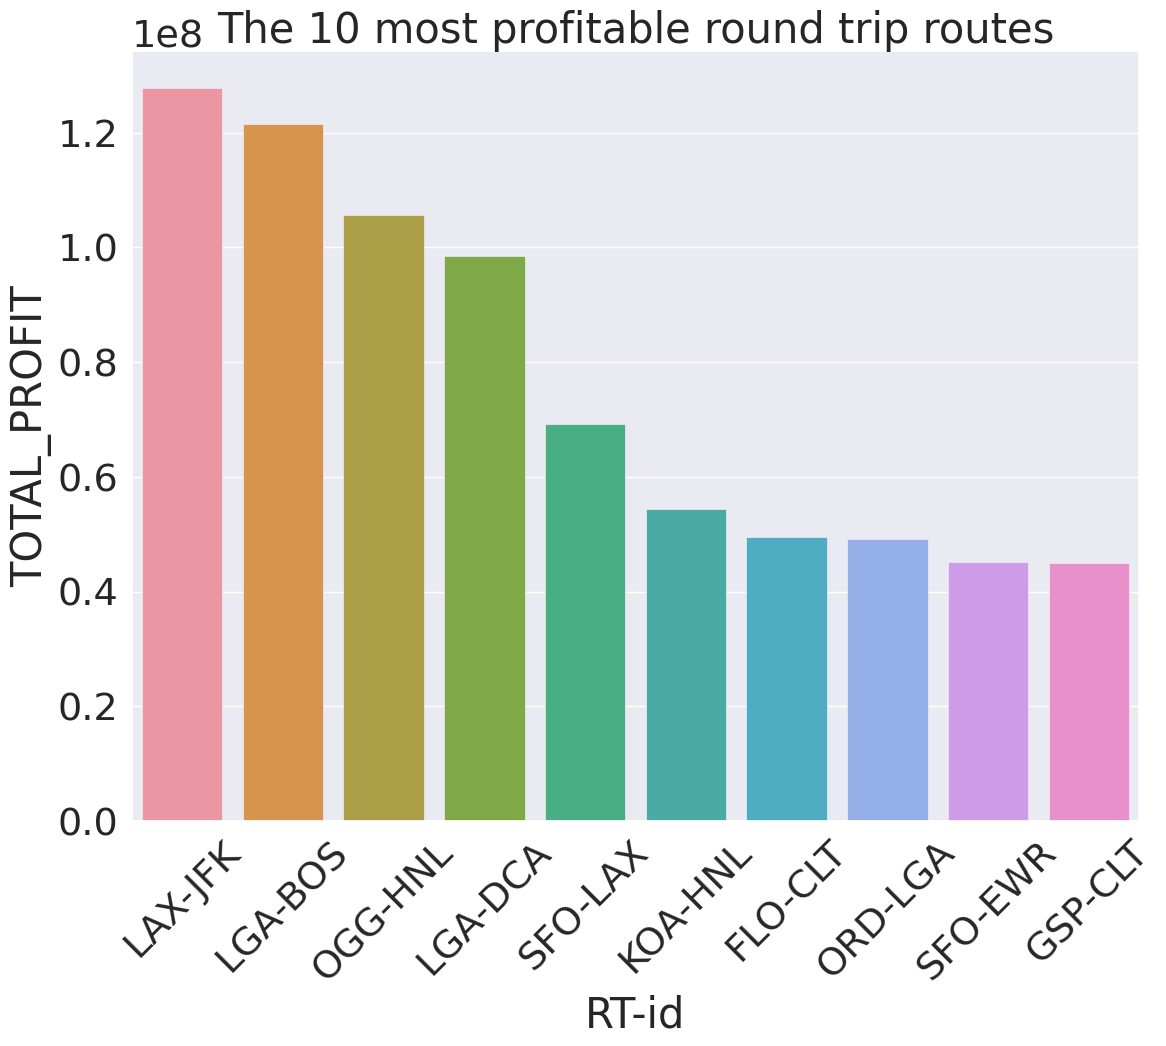

In [ ]:
bar_chart_plotter(most_profitable, 'RT-id', 'TOTAL_PROFIT', 'The 10 most profitable round trip routes', 45)

###  3 The 5 round trip routes that you recommend investing in based on any factors that you choose.

In [ ]:
cleaned_airport_codes_data[['NAME','IATA_CODE']][
    (cleaned_airport_codes_data['IATA_CODE'] == 'LAX') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'JFK') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'LGA') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'BOS') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'OGG') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'HNL') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'DCA') |
    (cleaned_airport_codes_data['IATA_CODE'] == 'SFO')
]

,NAME,IATA_CODE
1295,General Edward Lawrence Logan International Ai...,BOS
1375,Ronald Reagan Washington National Airport,DCA
1558,John F Kennedy International Airport,JFK
1571,Los Angeles International Airport,LAX
1586,La Guardia Airport,LGA
1823,San Francisco International Airport,SFO
2910,Daniel K Inouye International Airport,HNL
2912,Kahului Airport,OGG


Based on the wide gap in profit margin between these trips and others

I recommend that the company invest in
- LAX-JFK  (Los Angeles International Airport - John F Kennedy International Airport)
- LGA-BOS  (La Guardia Airport	-  General Edward Lawrence Logan International Airport)
- OGG-HNL  (Kahului Airport	-  Daniel K Inouye International Airport)
- LGA-DCA  (La Guardia Airport - Ronald Reagan Washington National Airport)
- SFO-LAX  (San Francisco International Airport	- Los Angeles International Airport)

In [ ]:
most_profitable

,RT-id,TOTAL_PROFIT,TOTAL_REVENUE,TOTAL_COST,PROFIT_PER_FLIGHT,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,ROUND_TRIP_COUNT
0,LAX-JFK,127798011.782,276671676.782,276671676.782,58355.257,126334.099,67978.842,2190
1,LGA-BOS,121498452.124,256640192.564,256640192.564,25412.770,53679.187,28266.417,4781
2,OGG-HNL,105691975.187,198082969.187,198082969.187,19649.001,36825.241,17176.240,5379
3,LGA-DCA,98414516.632,168864784.552,168864784.552,39006.943,66930.156,27923.214,2523
4,SFO-LAX,69157138.462,239790633.542,239790633.542,12703.369,44046.773,31343.405,5444
5,KOA-HNL,54324288.840,103948137.000,103948137.000,20031.080,38328.959,18297.879,2712
6,FLO-CLT,49451127.360,53182998.000,53182998.000,246025.509,264592.030,18566.521,201
7,ORD-LGA,49136300.563,201861980.963,201861980.963,12829.321,52705.478,39876.157,3830
8,SFO-EWR,45173423.055,90825258.455,90825258.455,71590.211,143938.603,72348.392,631
9,GSP-CLT,44958737.000,56559612.000,56559612.000,89917.474,113119.224,23201.750,500


In [ ]:
#selecting the top 5 you get
five_most_profitable=most_profitable.head()
five_most_profitable

,RT-id,TOTAL_PROFIT,TOTAL_REVENUE,TOTAL_COST,PROFIT_PER_FLIGHT,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,ROUND_TRIP_COUNT
0,LAX-JFK,127798011.782,276671676.782,276671676.782,58355.257,126334.099,67978.842,2190
1,LGA-BOS,121498452.124,256640192.564,256640192.564,25412.770,53679.187,28266.417,4781
2,OGG-HNL,105691975.187,198082969.187,198082969.187,19649.001,36825.241,17176.240,5379
3,LGA-DCA,98414516.632,168864784.552,168864784.552,39006.943,66930.156,27923.214,2523
4,SFO-LAX,69157138.462,239790633.542,239790633.542,12703.369,44046.773,31343.405,5444


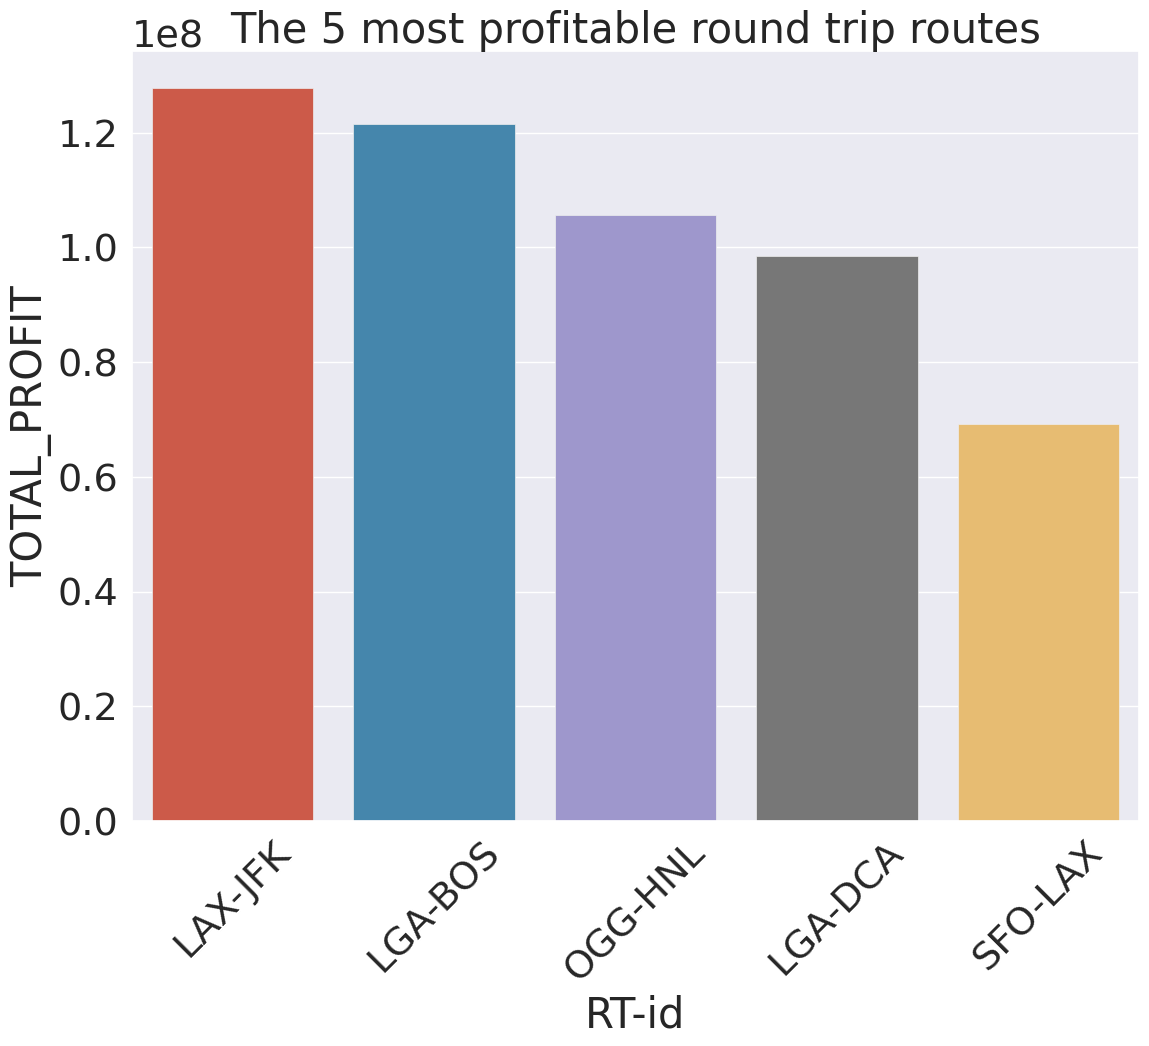

In [ ]:
bar_chart_plotter(five_most_profitable, 'RT-id', 'TOTAL_PROFIT', 'The 5 most profitable round trip routes', 45)

### 4 The number of round-trip flights it will take to breakeven on the upfront airplane cost for each of the 5 round trip routes that you recommend. Print key summary components for these routes.

In [ ]:
def break_even_calculator(rt):

    '''
        Calculates the number of flights needed to break even for each round trip

        New Field Metadata:
            'BREAK_EVEN_QTY': Shows number of flights needed to break even round trip
    '''

    airplane_cost = 90000000
    rt['BREAK_EVEN_QTY']=np.ceil(airplane_cost/(rt['PROFIT_PER_FLIGHT']))

    return rt

In [ ]:
break_even_data = five_most_profitable.apply(break_even_calculator, axis=1)
new_order = ['RT-id','BREAK_EVEN_QTY'] + [col for col in break_even_data.columns if col not in ['RT-id','BREAK_EVEN_QTY']]
break_even_data = break_even_data[new_order]
break_even_data

,RT-id,BREAK_EVEN_QTY,TOTAL_PROFIT,TOTAL_REVENUE,TOTAL_COST,PROFIT_PER_FLIGHT,REVENUE_PER_FLIGHT,COST_PER_FLIGHT,ROUND_TRIP_COUNT
0,LAX-JFK,1543.000,127798011.782,276671676.782,276671676.782,58355.257,126334.099,67978.842,2190
1,LGA-BOS,3542.000,121498452.124,256640192.564,256640192.564,25412.770,53679.187,28266.417,4781
2,OGG-HNL,4581.000,105691975.187,198082969.187,198082969.187,19649.001,36825.241,17176.240,5379
3,LGA-DCA,2308.000,98414516.632,168864784.552,168864784.552,39006.943,66930.156,27923.214,2523
4,SFO-LAX,7085.000,69157138.462,239790633.542,239790633.542,12703.369,44046.773,31343.405,5444


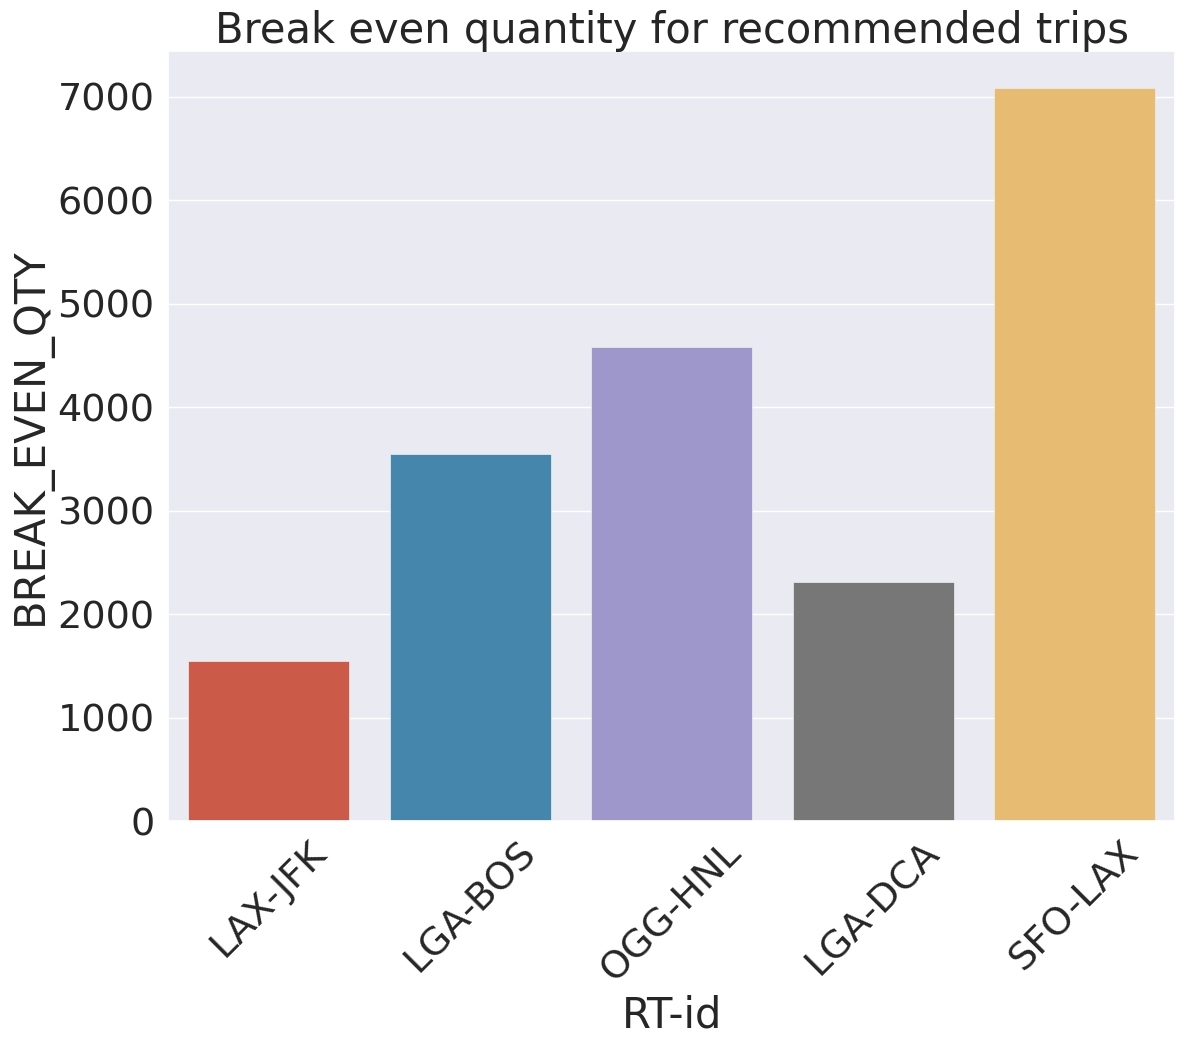

In [ ]:
bar_chart_plotter(break_even_data, 'RT-id', 'BREAK_EVEN_QTY', 'Break even quantity for recommended trips', 45)

### 5. Key Performance Indicators (KPI’s) that you recommend tracking in the future to measure the success of the round-trip routes that you recommend.

From the analysis carried out above it can be seeen that these parameters help to determine the overall cost and reveune and then profit associated with a route.

- Number of round trips (ROUND_TRIP_COUNT)

- Average occupation rate per flight (AVG_OCCUPANCY_RATE)

- Average cost of ticket for different airlines ( AVG_ITIN_FARE)

- Average penalizable initial depature delay (AVG_PEN_INITIAL_DEP_DELAY)

- Average penalizable initial arrival delay (AVG_PEN_INITIAL_ARR_DELAY)

- Average penalizable final depature delay (AVG_PEN_FINAL_DEP_DELAY)

- Average penalizable final arrival delay (AVG_PEN_FINAL_ARR_DELAY)

- Revenue per flight (REVENUE_PER_FLIGHT)

- Cost per flight (COST_PER_FLIGHT)

- Profit per flight (PROFIT_PER_FLIGHT)

- Total revenue (TOTAL_REVENUE)

- Total cost (TOTAL_COST)

- Total profit (TOTAL_PROFIT)

In [ ]:
def kpi_tracker (rt_data):
    kpi_data=rt_data.sort_values(by='TOTAL_PROFIT', ascending=False)[['RT-id','ROUND_TRIP_COUNT','AVG_OCCUPANCY_RATE','AVG_ITIN_FARE','AVG_PEN_INITIAL_DEP_DELAY','AVG_PEN_INITIAL_ARR_DELAY','AVG_PEN_FINAL_DEP_DELAY','AVG_PEN_FINAL_ARR_DELAY','TOTAL_PROFIT','TOTAL_REVENUE','TOTAL_COST','PROFIT_PER_FLIGHT','REVENUE_PER_FLIGHT','COST_PER_FLIGHT']].head(5).reset_index(drop=True)
    return kpi_data

In [ ]:
kpi_data = kpi_tracker (Total_Roundtrip_Finance)

In [ ]:
kpi_data

,RT-id,ROUND_TRIP_COUNT,AVG_OCCUPANCY_RATE,AVG_ITIN_FARE,AVG_PEN_INITIAL_DEP_DELAY,AVG_PEN_INITIAL_ARR_DELAY,AVG_PEN_FINAL_DEP_DELAY,AVG_PEN_FINAL_ARR_DELAY,TOTAL_PROFIT,TOTAL_REVENUE,TOTAL_COST,PROFIT_PER_FLIGHT,REVENUE_PER_FLIGHT,COST_PER_FLIGHT
0,LAX-JFK,2190,0.647,942.024,11.630,9.851,5.343,7.014,127798011.782,276671676.782,276671676.782,58355.257,126334.099,67978.842
1,LGA-BOS,4781,0.650,377.635,14.830,15.549,16.884,17.913,121498452.124,256640192.564,256640192.564,25412.770,53679.187,28266.417
2,OGG-HNL,5379,0.646,249.973,1.157,1.441,0.960,0.979,105691975.187,198082969.187,198082969.187,19649.001,36825.241,17176.240
3,LGA-DCA,2523,0.655,476.172,10.857,13.212,12.642,16.544,98414516.632,168864784.552,168864784.552,39006.943,66930.156,27923.214
4,SFO-LAX,5444,0.646,305.842,14.813,16.855,18.080,19.000,69157138.462,239790633.542,239790633.542,12703.369,44046.773,31343.405
